In [1]:
import os
import sys
import torch
import socket
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


import random
import spinup
import core_FPGA as core

from utils import weights_creation, create_input_tensor


In [2]:
N_EPISODES = 20

In [3]:
hidden_sizes = [core.N_HIDDEN_1, core.N_HIDDEN_2]

In [4]:
SAMPLE_RATE = 100000  # 100 kHz
TIME_STEP = 1 / SAMPLE_RATE

MAX_VAL = 32767
MAX_V_DAC = 5
MAX_V_ADC = 25

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [5]:
def compare_with_twin(random_numbers, model, deterministic, random, sample1, sample2, hls_outs):
    errors = []
    
    for step in range(core.N_STEPS):
        input_tensor = []
        for i in range(core.N_INPUT//2):
            input_tensor.append(sample1[step * core.N_INPUT//2 + i])
            input_tensor.append(sample2[step * core.N_INPUT//2 + i])
        input_tensor = torch.as_tensor(input_tensor, dtype=torch.float32, device=device).view(1, core.N_INPUT)
    
        out_brevitas = model(input_tensor)
        out_brevitas = out_brevitas.value

        # Split output into mu and log_std
        mu, log_std = torch.chunk(out_brevitas, 2, dim=-1)
        log_std = torch.clamp(log_std, core.LOG_STD_MIN, core.LOG_STD_MAX)
        std = torch.exp(log_std)

        print(f'Mu is: {mu.item()}, std is: {std.item()}')
        
        if deterministic:
            action = mu
            action = action.item()
        elif random:
            action = random_numbers[step]
        else:    
            action = random_numbers[step] * std + mu
            action = action.item()

        action = np.tanh(action)
        action = core.ACT_LIM * action

        action_hls = hls_outs[step]

        if step == core.N_STEPS-1:
            action = -core.ACT_LIM
        error = (action_hls-action)/(action_hls+1e-12) * 100
        errors.append(error)

        if abs(error) > 1.:
            print("From HLS", action_hls)
            print("From Brevitas", action)

        # print("From HLS", action_hls)
        # print("From Brevitas", action)
    
    print(errors)
    # Plot the error
    plt.figure(figsize=(10, 4))
    plt.plot(range(core.N_STEPS), errors, label='Error ')
    plt.title('Action Percentage Error Over One Episode')
    plt.xlabel('Step')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return errors

In [6]:
def plot_data(sample1, sample2, actions):
    t = np.arange(len(sample1)) * TIME_STEP

    # Prepare the actions
    action_repeated = np.repeat(actions, core.N_INPUT // 2)

    # Define figure size
    fig_size = (10, 8)

    # Create a figure with two subplots
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=fig_size, sharex=True)

    # Plotting Sample 1 with secondary axis for actions
    ax2 = ax1.twinx()
    ax1.plot(t, np.array(sample1) / MAX_VAL * MAX_V_ADC, label='Sample 1', color='b')
    ax2.plot(t, action_repeated / MAX_VAL * MAX_V_ADC, label='Actions', linestyle='--', color='r')

    ax1.set_title('Sample 1 Over Time')
    ax1.set_ylabel('Sample 1 Amplitude (V)', color='b')
    ax2.set_ylabel('Actions Amplitude (V)', color='r')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)

    # Plotting Sample 2 with secondary axis for actions
    ax4 = ax3.twinx()
    ax3.plot(t, np.array(sample2) / MAX_VAL * MAX_V_ADC, label='Sample 2', color='g')
    ax4.plot(t, action_repeated / MAX_VAL * MAX_V_ADC, label='Actions', linestyle='--', color='r')

    ax3.set_title('Sample 2 Over Time')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Sample 2 Amplitude (V)', color='g')
    ax4.set_ylabel('Actions Amplitude (V)', color='r')

    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')
    ax3.grid(True)

    plt.show()
    
def save_data(sample1, sample2, actions, run_number, experiment_folder):
    # Ensure the directory exists
    os.makedirs(experiment_folder, exist_ok=True)

    action_repeated = np.repeat(actions, core.N_INPUT // 2)

    # Prepare data and convert to DataFrame
    data = {
        'Time': np.arange(len(sample1)) * TIME_STEP,
        'Sample1': sample1,
        'Sample2': sample2,
        'Actions': action_repeated
    }
    df = pd.DataFrame(data)

    # Save to Parquet file in the specified folder
    file_path = os.path.join(experiment_folder, f'data_run_{run_number}.parquet')
    df.to_parquet(file_path)
    print(f"Data for run {run_number} saved to {file_path}")

def request_and_receive_data(server_ip, server_port, experiment_folder):
    
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client.settimeout(60 * 60)  # Set the timeout for blocking socket operations, 1h
    client.connect((server_ip, server_port))
    
    errors = []

    # Istantiate the digital twin 
    model = core.Digital_twin(core.N_INPUT, 1, hidden_sizes, device).to(device)

    # Generate a random uniform number 
    x = np.random.uniform(low=-1.0, high=1.0)
    
    # Generate a random uniform number between core.LOG_STD_MIN and core.LOG_STD_MAX for y
    y = np.random.uniform(low=core.LOG_STD_MIN, high=core.LOG_STD_MAX)
    
    # Create a tensor with the random numbers x and y
    target = torch.tensor([x, y], dtype=torch.float32).to(device)
    
    print(f'Target is: [{target[0].item()}, {target[1].item()}]')
    
    # Define the loss function (MSE Loss)
    criterion = nn.MSELoss()
    
    # Define the optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("First time, creating random data")
    
    # Have to run inference once - create random data
    in_float = create_input_tensor(core.N_INPUT, device)
    
    model.eval()
    
    out_brevitas = model(in_float)

    scale = float(out_brevitas.scale[0, 0])  

    for ep in range(N_EPISODES):

        weights_list, random_numbers = weights_creation(model, scale, ep)
        
        print(f"Ready for Run {ep}/{N_EPISODES-1}:")
        
        # Serialize and send the weights list; here, each weight is packed as a single byte, reflecting the int8 data type.
        packed_weights = b''.join(struct.pack('<b', weight) for weight in weights_list)
        client.send(packed_weights) # Send it all 

        print("Done streaming weights.")
        
        obs, actions = core.receive_data_episode(client, core.N_STEPS * core.N_INPUT, core.N_STEPS)

        ORs = []
        OEs = []
        for o in obs:
            # Extract values based on even and odd indices
            OR_values = o[::2]  # Values at even indices
            OE_values = o[1::2] # Values at odd indices

            ORs.extend(OR_values)
            OEs.extend(OE_values)
        
        plot_data(ORs, OEs, actions)
        save_data(ORs, OEs, actions, ep, experiment_folder)

        if ((ep % core.EPISODE_PER_EPOCH) == 0):
            deterministic = True
        else:
            deterministic = False

        if ep < core.START_EPISODE:
            random = True
        else:
            random = False

        # random = False
        # deterministic = False

        print('Deterministic: ', deterministic, 'random: ', random)
        error = compare_with_twin(random_numbers, model, deterministic, random, ORs, OEs, actions)
        errors.extend(error)

        model.train()
        
        for o in obs:      
            o = torch.as_tensor(o, dtype=torch.float32, device=device).view(1, -1)
            # Forward pass: Compute the model output
            out_brevitas = model(o)
            scale = float(out_brevitas.scale[0])  
            
            # Compute the loss
            loss = criterion(out_brevitas, target)
            
            # Zero the gradients before running the backward pass
            optimizer.zero_grad()
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Update the model parameters
            optimizer.step()
            
            # Print the loss for monitoring 
            print(f"Loss: {loss.item()}")
    
        
    client.close()

    return errors
            
    # except ConnectionResetError:
    #     print(f"Connection was reset during run {run}. Attempting to reconnect...")
    # except Exception as e:
    #     print(f"An error occurred: {e}")

Target is: [-0.7955135703086853, -8.92197322845459]
First time, creating random data


C:\Users\giuli\Anaconda3\envs\brevitas_env\Lib\site-packages\torch\_tensor.py:1413: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/core/TensorImpl.h:1928.)
  return super().rename(names)


Sent Scale: 3.987846294503661e-13
Ready for Run 0/19:
Done streaming weights.
Number of received actions: 324


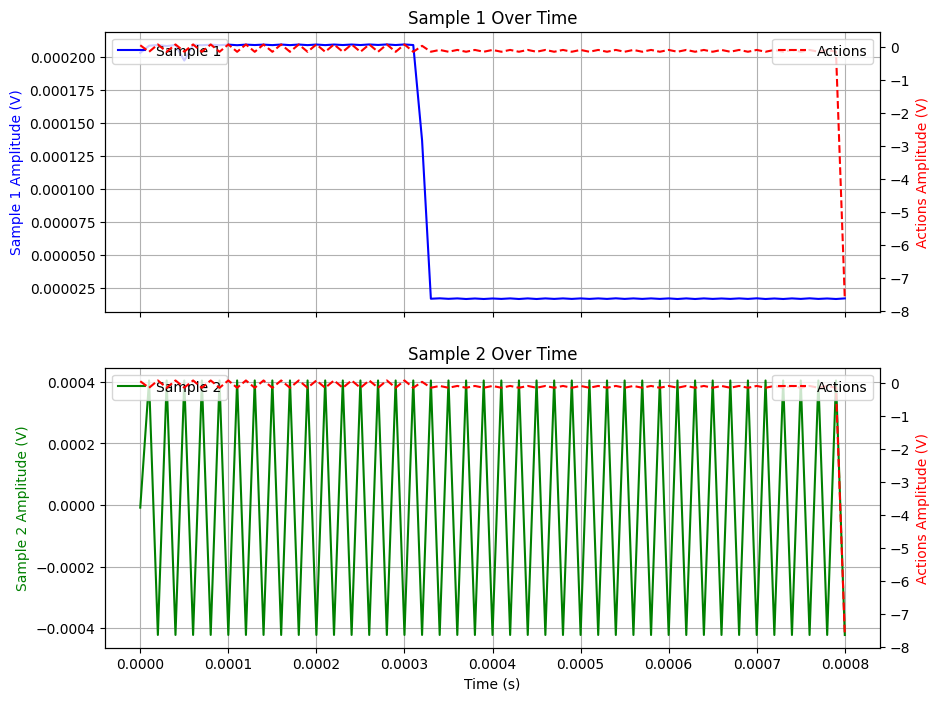

Data for run 0 saved to test\data_run_0.parquet
Deterministic:  True random:  True
Mu is: 0.005481494124978781, std is: 1.013993740081787
Mu is: -0.020511452108621597, std is: 1.0122038125991821
Mu is: 0.008601473644375801, std is: 1.0396264791488647
Mu is: -0.020501967519521713, std is: 1.0122045278549194
Mu is: 0.008605660870671272, std is: 1.039629578590393
Mu is: -0.019956879317760468, std is: 1.0120608806610107
Mu is: 0.008618207648396492, std is: 1.039638638496399
Mu is: -0.020524563267827034, std is: 1.012201189994812
Mu is: 0.008618978783488274, std is: 1.0396339893341064
Mu is: -0.020524563267827034, std is: 1.012201189994812
Mu is: 0.008622386492788792, std is: 1.0396416187286377
Mu is: -0.020524563267827034, std is: 1.012201189994812
Mu is: 0.008622386492788792, std is: 1.0396416187286377
Mu is: -0.020528927445411682, std is: 1.0122003555297852
Mu is: 0.008622386492788792, std is: 1.0396416187286377
Mu is: -0.020526740700006485, std is: 1.0122008323669434
Mu is: 0.0086257942

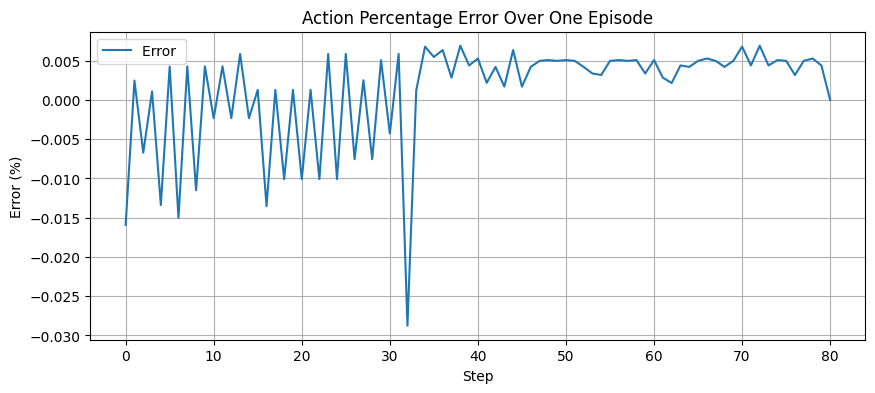

C:\Users\giuli\Anaconda3\envs\brevitas_env\Lib\site-packages\brevitas\quant_tensor\__init__.py:93: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Loss: 40.24568557739258
Loss: 40.12974548339844
Loss: 40.20762252807617
Loss: 39.87661361694336
Loss: 39.91543960571289
Loss: 39.641048431396484
Loss: 39.62459182739258
Loss: 39.377586364746094
Loss: 39.32910919189453
Loss: 39.126441955566406
Loss: 39.04439163208008
Loss: 38.875953674316406
Loss: 38.76874542236328
Loss: 38.61958694458008
Loss: 38.49824523925781
Loss: 38.35634231567383
Loss: 38.228187561035156
Loss: 38.0881233215332
Loss: 37.95250701904297
Loss: 37.82087326049805
Loss: 37.67753601074219
Loss: 37.53099822998047
Loss: 37.40711212158203
Loss: 37.228939056396484
Loss: 37.11810302734375
Loss: 36.92351531982422
Loss: 36.84205627441406
Loss: 36.59050369262695
Loss: 36.545738220214844
Loss: 36.27986526489258
Loss: 36.227943420410156
Loss: 35.95246505737305
Loss: 36.258609771728516
Loss: 36.31962203979492
Loss: 36.434654235839844
Loss: 35.98406982421875
Loss: 36.13072967529297
Loss: 35.625465393066406
Loss: 35.80552673339844
Loss: 35.27488327026367
Loss: 35.462318420410156
Loss:

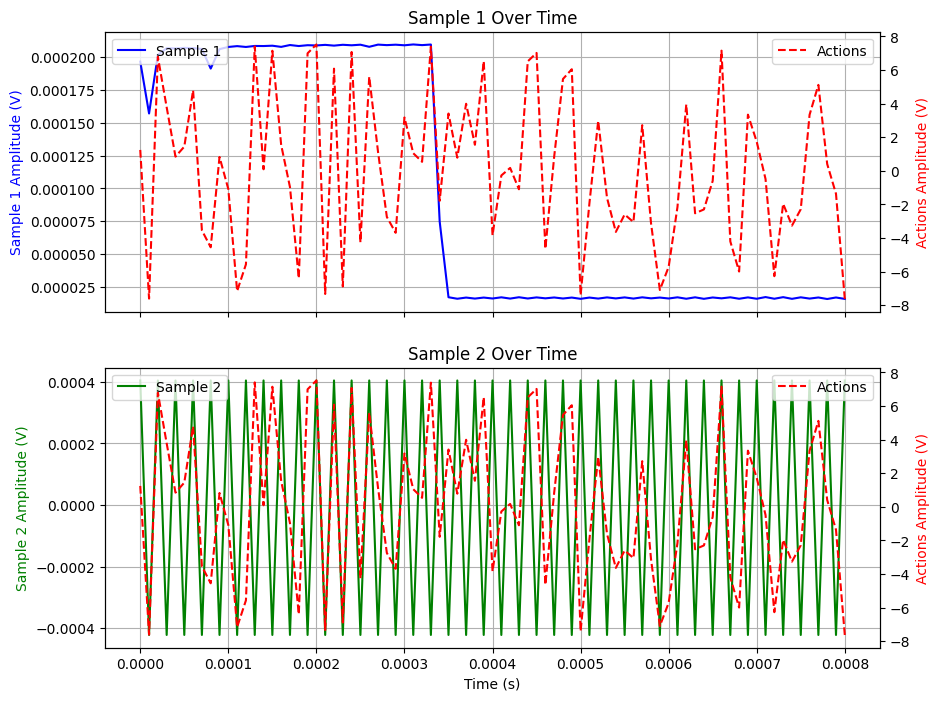

Data for run 1 saved to test\data_run_1.parquet
Deterministic:  False random:  True
Mu is: -0.8192585110664368, std is: 0.12176167964935303
Mu is: -0.6564396619796753, std is: 0.13740907609462738
Mu is: -0.8215481042861938, std is: 0.12104810774326324
Mu is: -0.6754728555679321, std is: 0.1276155263185501
Mu is: -0.8238617181777954, std is: 0.12033124268054962
Mu is: -0.6755009889602661, std is: 0.12759414315223694
Mu is: -0.8239818215370178, std is: 0.12029412388801575
Mu is: -0.6752120852470398, std is: 0.1277378350496292
Mu is: -0.8169612288475037, std is: 0.122504323720932
Mu is: -0.6751542091369629, std is: 0.12776507437229156
Mu is: -0.8244025707244873, std is: 0.12016426771879196
Mu is: -0.6762843728065491, std is: 0.1272435337305069
Mu is: -0.8244025707244873, std is: 0.12016426771879196
Mu is: -0.6762546300888062, std is: 0.12724927067756653
Mu is: -0.8248471617698669, std is: 0.12002714723348618
Mu is: -0.6763415336608887, std is: 0.12720859050750732
Mu is: -0.824546694755554

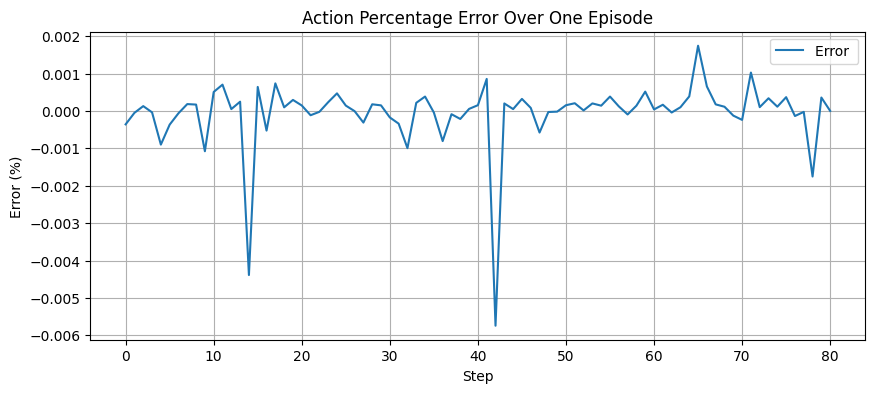

Loss: 23.231143951416016
Loss: 23.717933654785156
Loss: 22.457069396972656
Loss: 22.492887496948242
Loss: 21.6824893951416
Loss: 21.723190307617188
Loss: 20.908294677734375
Loss: 20.976165771484375
Loss: 20.255084991455078
Loss: 20.16726303100586
Loss: 19.260234832763672
Loss: 19.319608688354492
Loss: 18.482017517089844
Loss: 18.51675033569336
Loss: 17.694358825683594
Loss: 17.634939193725586
Loss: 16.8513126373291
Loss: 16.772951126098633
Loss: 16.050765991210938
Loss: 15.928458213806152
Loss: 15.19875717163086
Loss: 15.093169212341309
Loss: 14.374944686889648
Loss: 14.276666641235352
Loss: 13.514863014221191
Loss: 13.391870498657227
Loss: 12.73189926147461
Loss: 12.533730506896973
Loss: 11.924962997436523
Loss: 11.704535484313965
Loss: 11.158546447753906
Loss: 10.890089988708496
Loss: 10.37044620513916
Loss: 10.068777084350586
Loss: 11.219178199768066
Loss: 12.81330394744873
Loss: 10.935345649719238
Loss: 12.130733489990234
Loss: 10.271696090698242
Loss: 11.417927742004395
Loss: 9.58

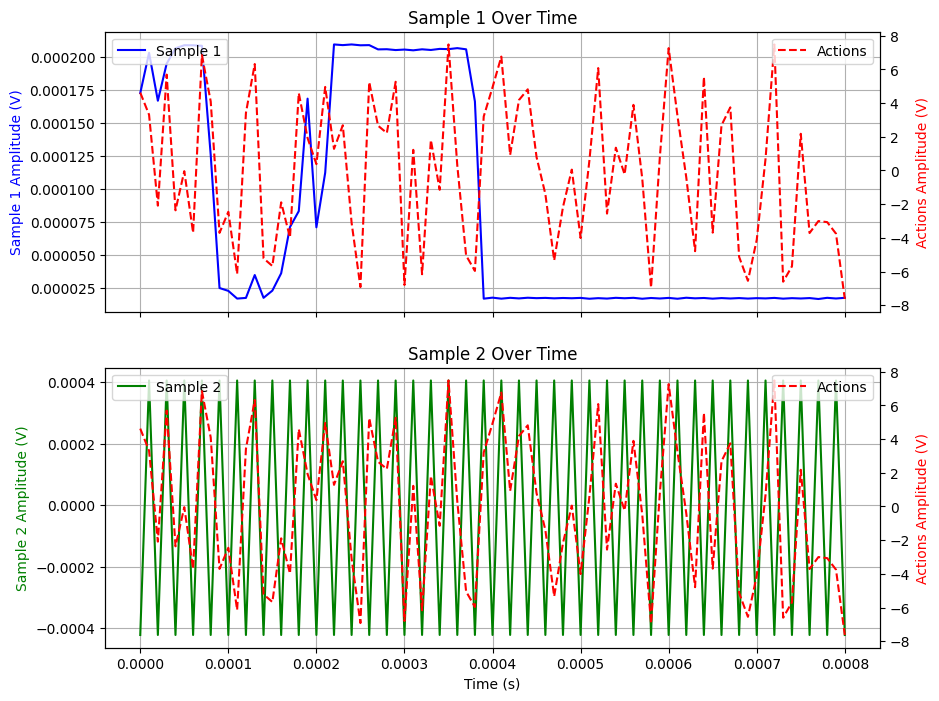

Data for run 2 saved to test\data_run_2.parquet
Deterministic:  False random:  True
Mu is: -0.8852924704551697, std is: 0.00022843664919491857
Mu is: -0.8273410797119141, std is: 0.0002764160162769258
Mu is: -0.8817420601844788, std is: 0.00023831299040466547
Mu is: -0.8227422833442688, std is: 0.00028971079154871404
Mu is: -0.9083840847015381, std is: 0.00017646174819674343
Mu is: -0.8303930759429932, std is: 0.0002679120807442814
Mu is: -0.9099597334861755, std is: 0.00017339823534712195
Mu is: -0.8301496505737305, std is: 0.0002685800427570939
Mu is: -0.8576122522354126, std is: 0.000317615078529343
Mu is: -0.7944402694702148, std is: 0.0004700237768702209
Mu is: -0.8072015047073364, std is: 0.0005921527044847608
Mu is: -0.7940812110900879, std is: 0.0004770766827277839
Mu is: -0.8046370148658752, std is: 0.0006113218259997666
Mu is: -0.79488205909729, std is: 0.0004614899808075279
Mu is: -0.8045475482940674, std is: 0.0006117623997852206
Mu is: -0.7943520545959473, std is: 0.000471

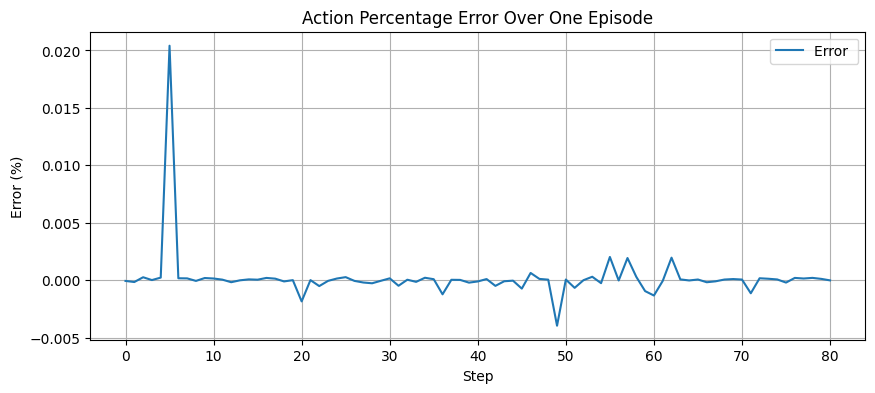

Loss: 0.14860239624977112
Loss: 0.2274286299943924
Loss: 0.10401967167854309
Loss: 0.18177317082881927
Loss: 0.003901256714016199
Loss: 0.09193515032529831
Loss: 0.00468854745849967
Loss: 0.05337582528591156
Loss: 0.10218413174152374
Loss: 0.3276035189628601
Loss: 0.528014600276947
Loss: 0.28593096137046814
Loss: 0.49456697702407837
Loss: 0.20715343952178955
Loss: 0.42997780442237854
Loss: 0.17938323318958282
Loss: 0.2742275297641754
Loss: 0.09530308097600937
Loss: 0.06598661839962006
Loss: 0.006768044549971819
Loss: 0.0697440579533577
Loss: 0.024574341252446175
Loss: 0.2638813555240631
Loss: 0.029979871585965157
Loss: 0.2860164940357208
Loss: 0.0392284169793129
Loss: 0.2902950048446655
Loss: 0.03779810294508934
Loss: 0.2644463777542114
Loss: 0.037805937230587006
Loss: 0.24554872512817383
Loss: 0.03804754838347435
Loss: 0.22687485814094543
Loss: 0.0377177968621254
Loss: 0.19846591353416443
Loss: 0.03363683447241783
Loss: 0.17419499158859253
Loss: 0.02994515188038349
Loss: 0.02790807001

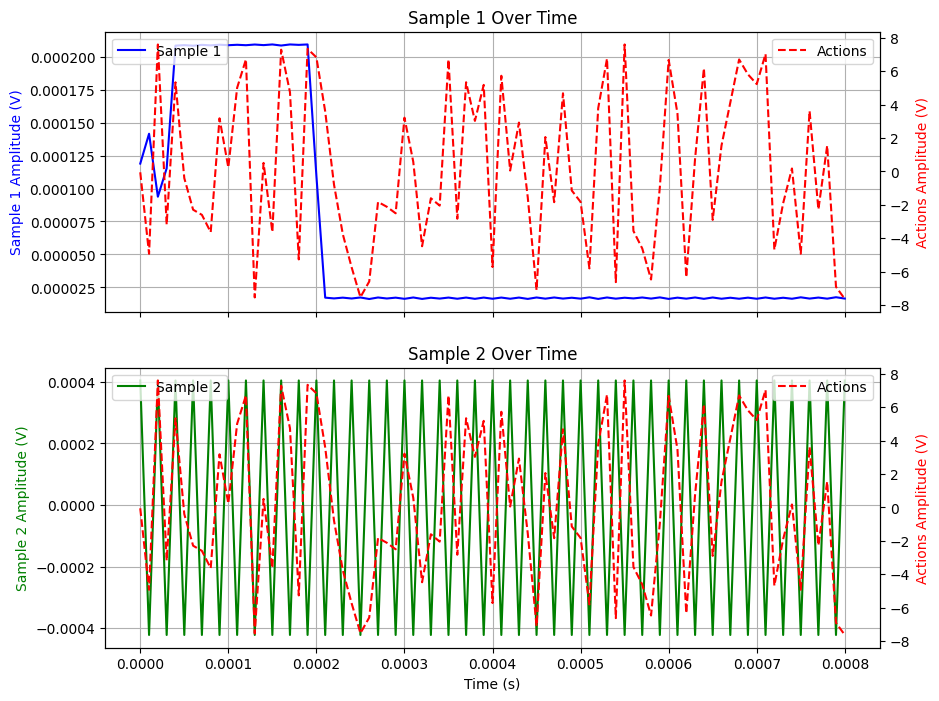

Data for run 3 saved to test\data_run_3.parquet
Deterministic:  False random:  True
Mu is: -0.7944196462631226, std is: 0.00010875028965529054
Mu is: -0.8640572428703308, std is: 6.839864363428205e-05
Mu is: -0.7940690517425537, std is: 0.00011396638728911057
Mu is: -0.8513801693916321, std is: 8.214948320528492e-05
Mu is: -0.8153664469718933, std is: 7.635953079443425e-05
Mu is: -0.8986103534698486, std is: 4.1427640098845586e-05
Mu is: -0.8153349757194519, std is: 7.638903480255976e-05
Mu is: -0.8988285660743713, std is: 4.131487730774097e-05
Mu is: -0.8154605627059937, std is: 7.627109880559146e-05
Mu is: -0.8988944888114929, std is: 4.127513966523111e-05
Mu is: -0.8155233860015869, std is: 7.621235272381455e-05
Mu is: -0.8987423181533813, std is: 4.134802657063119e-05
Mu is: -0.8155233860015869, std is: 7.621235272381455e-05
Mu is: -0.8988415002822876, std is: 4.128841101191938e-05
Mu is: -0.8155547976493835, std is: 7.618284871568903e-05
Mu is: -0.8988745212554932, std is: 4.12684

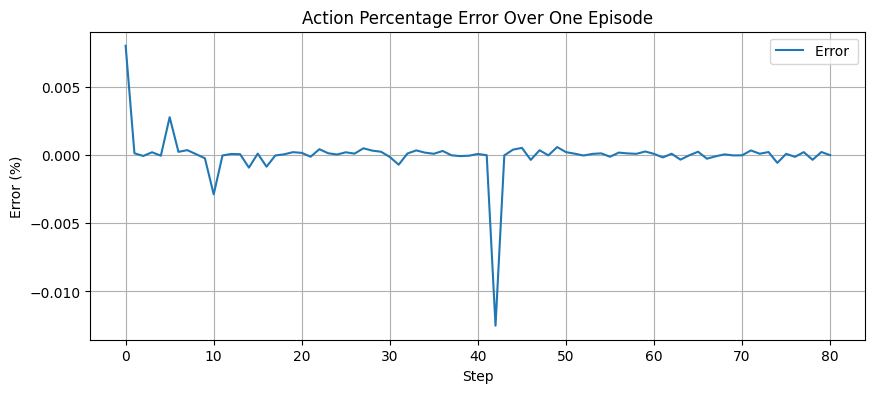

Loss: 0.02090725302696228
Loss: 0.23524868488311768
Loss: 0.01304560899734497
Loss: 0.12792149186134338
Loss: 0.1593303084373474
Loss: 0.7019484639167786
Loss: 0.14993594586849213
Loss: 0.6505903005599976
Loss: 0.13481396436691284
Loss: 0.5883127450942993
Loss: 0.11441970616579056
Loss: 0.5133835077285767
Loss: 0.09268505871295929
Loss: 0.43120482563972473
Loss: 0.07079730927944183
Loss: 0.3471391201019287
Loss: 0.05146535485982895
Loss: 0.2695299983024597
Loss: 0.037752535194158554
Loss: 0.21144253015518188
Loss: 0.006353993900120258
Loss: 0.17744092643260956
Loss: 0.041908588260412216
Loss: 0.20392228662967682
Loss: 0.0467090904712677
Loss: 0.21997393667697906
Loss: 0.048873648047447205
Loss: 0.2256774604320526
Loss: 0.04958118870854378
Loss: 0.22402262687683105
Loss: 0.04648531973361969
Loss: 0.2155001014471054
Loss: 0.0434272363781929
Loss: 0.20087821781635284
Loss: 0.03863641247153282
Loss: 0.18128545582294464
Loss: 0.032196078449487686
Loss: 0.15655426681041718
Loss: 0.0257414188

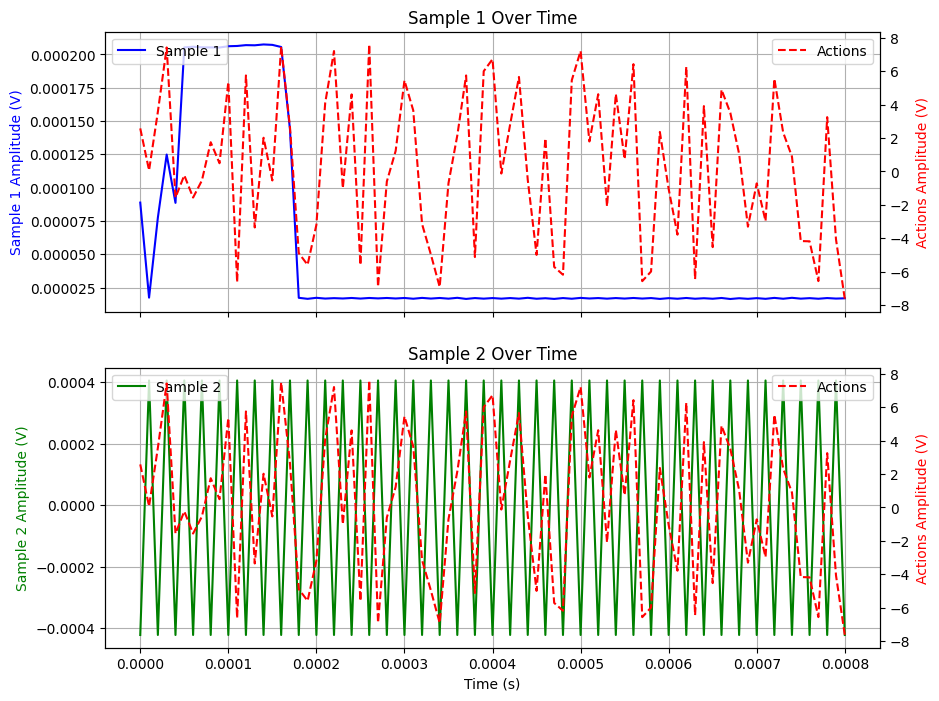

Data for run 4 saved to test\data_run_4.parquet
Deterministic:  False random:  True
Mu is: -0.8130089640617371, std is: 8.850759331835434e-05
Mu is: -0.8002617955207825, std is: 0.00012740815873257816
Mu is: -0.8093208074569702, std is: 9.411713836016133e-05
Mu is: -0.7968920469284058, std is: 0.00010947316332021728
Mu is: -0.8129487037658691, std is: 8.859761146595702e-05
Mu is: -0.8083555102348328, std is: 8.535785309504718e-05
Mu is: -0.856476366519928, std is: 4.385402280604467e-05
Mu is: -0.8083833456039429, std is: 8.53279052535072e-05
Mu is: -0.8562689423561096, std is: 4.400035322760232e-05
Mu is: -0.8084402084350586, std is: 8.527762838639319e-05
Mu is: -0.8567485213279724, std is: 4.3687468860298395e-05
Mu is: -0.8088308572769165, std is: 8.48484123707749e-05
Mu is: -0.8570857644081116, std is: 4.345170600572601e-05
Mu is: -0.8091675043106079, std is: 8.450021414319053e-05
Mu is: -0.8571768999099731, std is: 4.336402707849629e-05
Mu is: -0.8091945648193359, std is: 8.44606547

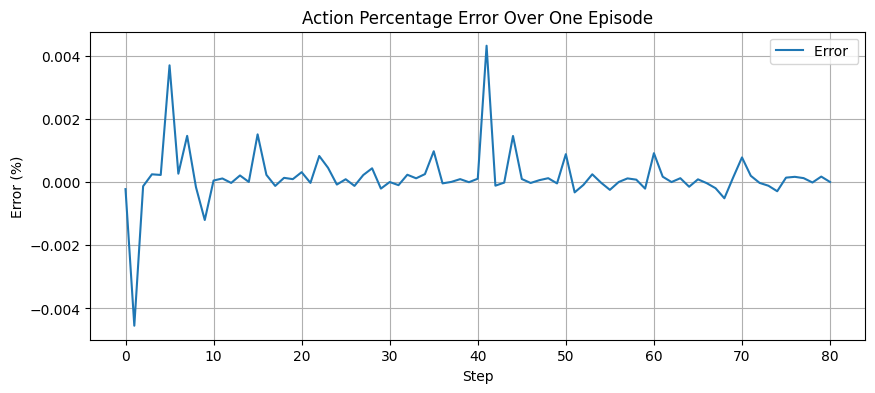

Loss: 0.08438724279403687
Loss: 0.0009904373437166214
Loss: 0.059169597923755646
Loss: 0.018096910789608955
Loss: 0.07610473036766052
Loss: 0.09140519797801971
Loss: 0.5606548190116882
Loss: 0.08097022771835327
Loss: 0.5069319605827332
Loss: 0.06912650913000107
Loss: 0.45519331097602844
Loss: 0.054130587726831436
Loss: 0.3770647943019867
Loss: 0.04004892334342003
Loss: 0.29536837339401245
Loss: 0.02783641591668129
Loss: 0.223332941532135
Loss: 0.0009517300641164184
Loss: 0.0826948955655098
Loss: 0.021581929177045822
Loss: 0.10382413864135742
Loss: 0.024735083803534508
Loss: 0.11966632306575775
Loss: 0.02733435109257698
Loss: 0.12499378621578217
Loss: 0.02835783362388611
Loss: 0.12601429224014282
Loss: 0.02816452458500862
Loss: 0.12337431311607361
Loss: 0.02651195041835308
Loss: 0.11699862033128738
Loss: 0.023181669414043427
Loss: 0.10540661215782166
Loss: 0.01788918487727642
Loss: 0.09428887814283371
Loss: 0.013242269866168499
Loss: 0.07996410876512527
Loss: 0.010305377654731274
Loss: 

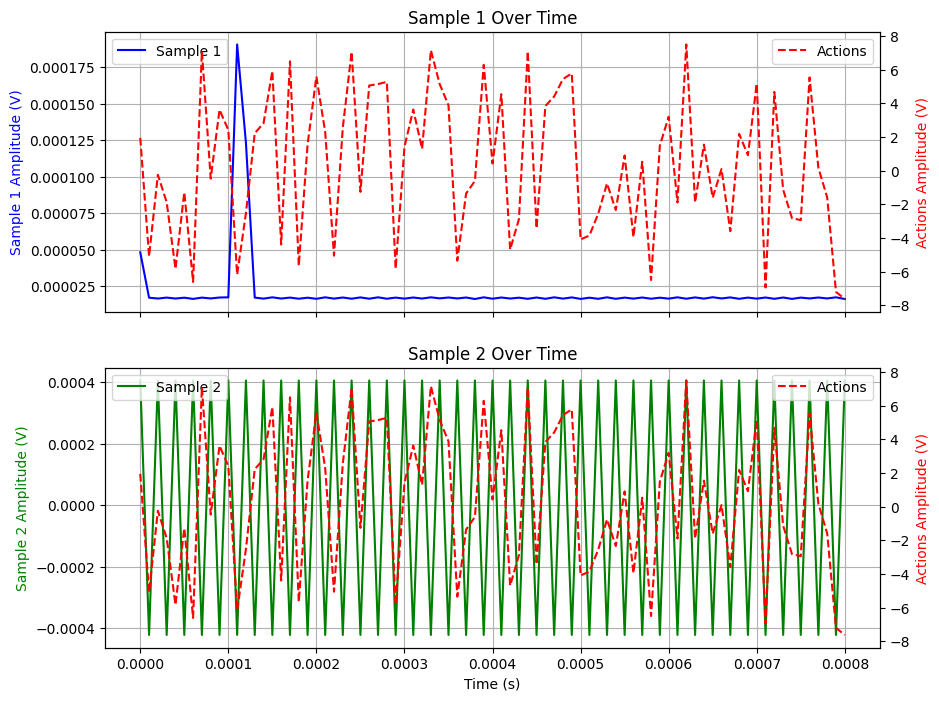

Data for run 5 saved to test\data_run_5.parquet
Deterministic:  False random:  True
Mu is: -0.7960060834884644, std is: 0.0001268498454010114
Mu is: -0.7938461899757385, std is: 0.00013018138997722417
Mu is: -0.7979832887649536, std is: 0.0001313238317379728
Mu is: -0.7938618659973145, std is: 0.00013014377327635884
Mu is: -0.7979832887649536, std is: 0.0001313238317379728
Mu is: -0.7938461899757385, std is: 0.00013018138997722417
Mu is: -0.7980000972747803, std is: 0.00013135890185367316
Mu is: -0.7938618659973145, std is: 0.00013014377327635884
Mu is: -0.7979791164398193, std is: 0.00013131494051776826
Mu is: -0.7937586307525635, std is: 0.00013028048851992935
Mu is: -0.7979283928871155, std is: 0.00013120965741109103
Mu is: -0.8406333923339844, std is: 5.6744123867247254e-05
Mu is: -0.7908923029899597, std is: 0.00011739045294234529
Mu is: -0.7938618659973145, std is: 0.00013014377327635884
Mu is: -0.7979874610900879, std is: 0.00013133247557561845
Mu is: -0.7937897443771362, std is

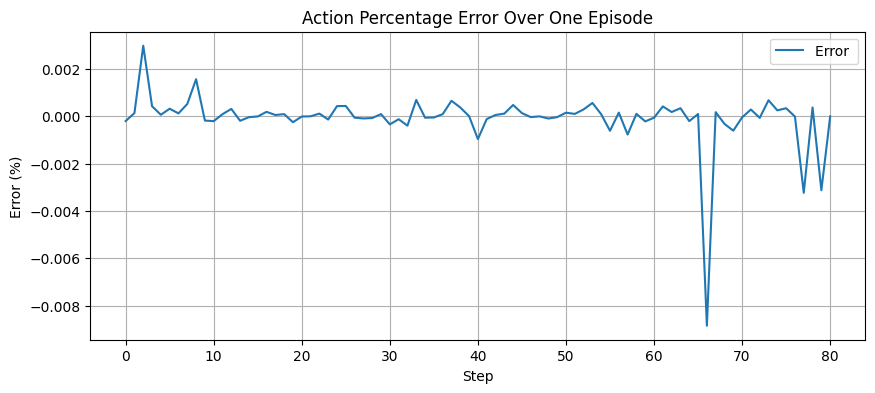

Loss: 0.0012769282329827547
Loss: 0.0002978981356136501
Loss: 9.789978503249586e-05
Loss: 0.0002913293428719044
Loss: 3.2893996831262484e-05
Loss: 0.000255069462582469
Loss: 2.032037082244642e-05
Loss: 0.00022354711836669594
Loss: 6.67286303723813e-06
Loss: 0.00017806216783355922
Loss: 6.02044201514218e-06
Loss: 0.3581104874610901
Loss: 0.006048137322068214
Loss: 8.117276593111455e-06
Loss: 4.2308376578148454e-05
Loss: 0.00024730199947953224
Loss: 0.0001310629304498434
Loss: 0.0009719458175823092
Loss: 0.000155921297846362
Loss: 0.0012900017900392413
Loss: 0.0001084183604689315
Loss: 0.001789312344044447
Loss: 0.00015391573833767325
Loss: 0.00197487510740757
Loss: 0.000201489296159707
Loss: 0.002042965730652213
Loss: 0.00020124473667237908
Loss: 0.0023902589455246925
Loss: 0.00022358816931955516
Loss: 0.0020448097493499517
Loss: 0.00019989653083030134
Loss: 0.0018736798083409667
Loss: 0.00014240290329325944
Loss: 0.0016577489441260695
Loss: 8.637159044155851e-05
Loss: 0.001217405893839

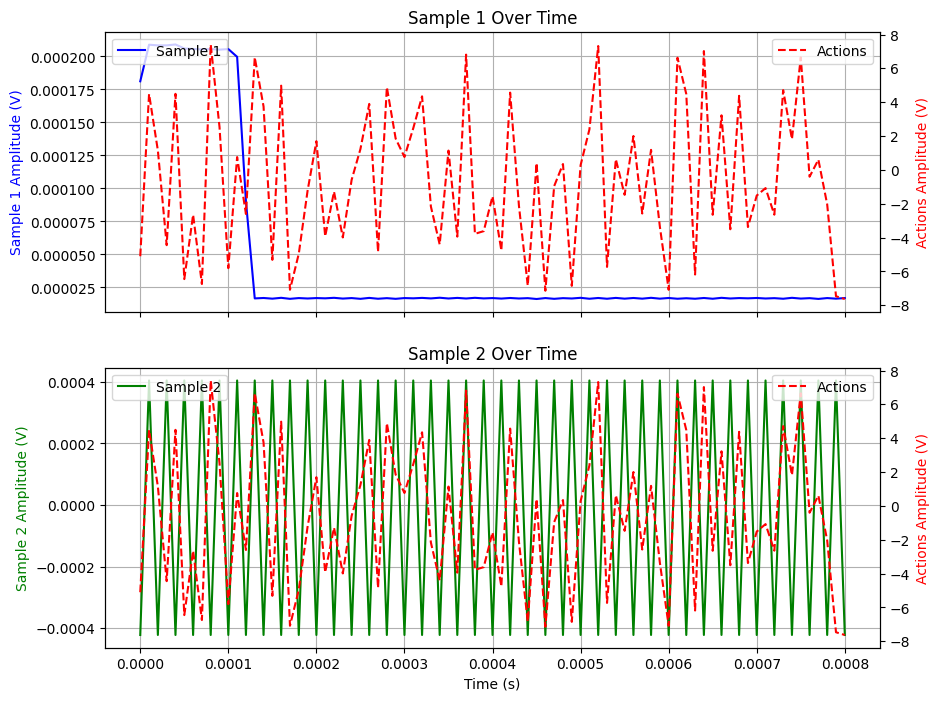

Data for run 6 saved to test\data_run_6.parquet
Deterministic:  False random:  True
Mu is: -0.8350054621696472, std is: 6.201849464559928e-05
Mu is: -0.797773540019989, std is: 9.513279655948281e-05
Mu is: -0.8441349267959595, std is: 5.328858605935238e-05
Mu is: -0.7975682616233826, std is: 9.538126323604956e-05
Mu is: -0.8445534706115723, std is: 5.298438554746099e-05
Mu is: -0.7966185808181763, std is: 9.653872257331386e-05
Mu is: -0.8430560827255249, std is: 5.415248597273603e-05
Mu is: -0.7963364124298096, std is: 9.688550926512107e-05
Mu is: -0.8430283665657043, std is: 5.417439024313353e-05
Mu is: -0.7962594032287598, std is: 9.698035864857957e-05
Mu is: -0.8429147601127625, std is: 5.424397750175558e-05
Mu is: -0.7940524220466614, std is: 9.973787382477894e-05
Mu is: -0.8098635673522949, std is: 9.638178016757593e-05
Mu is: -0.7961263060569763, std is: 0.0001333986292593181
Mu is: -0.7924121022224426, std is: 0.00013319688150659204
Mu is: -0.7961393594741821, std is: 0.00013342

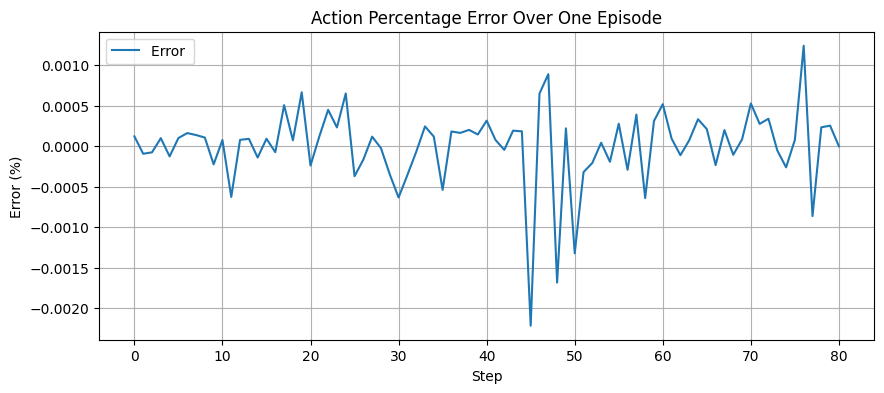

Loss: 0.29423800110816956
Loss: 0.05695163086056709
Loss: 0.4028220772743225
Loss: 0.04904679208993912
Loss: 0.36161455512046814
Loss: 0.04009426012635231
Loss: 0.28356048464775085
Loss: 0.0299361702054739
Loss: 0.22718432545661926
Loss: 0.021792175248265266
Loss: 0.17148256301879883
Loss: 0.008581006899476051
Loss: 0.0020013656467199326
Loss: 0.015879618003964424
Loss: 0.07542107254266739
Loss: 0.019219620153307915
Loss: 0.09094730764627457
Loss: 0.019759176298975945
Loss: 0.09786081314086914
Loss: 0.019944190979003906
Loss: 0.09864934533834457
Loss: 0.019275367259979248
Loss: 0.09556329995393753
Loss: 0.017487196251749992
Loss: 0.08795391023159027
Loss: 0.014413271099328995
Loss: 0.07717738300561905
Loss: 0.011097379960119724
Loss: 0.06617691367864609
Loss: 0.00838729739189148
Loss: 0.052551716566085815
Loss: 0.005146723706275225
Loss: 0.04161662980914116
Loss: 0.0028039151802659035
Loss: 0.031676050275564194
Loss: 0.0016137666534632444
Loss: 0.023389942944049835
Loss: 0.000582565495

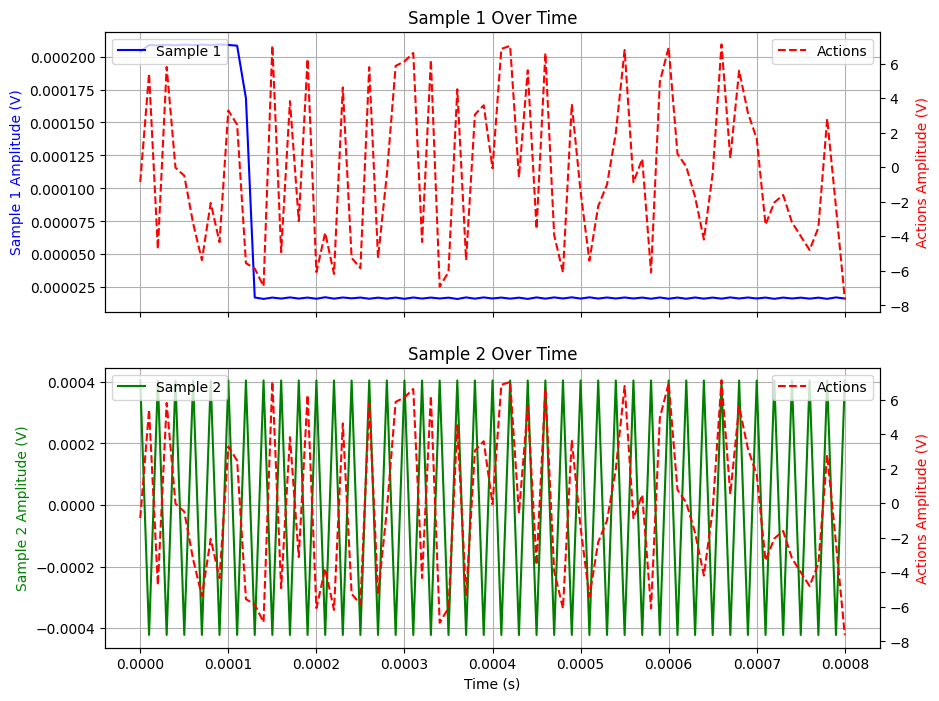

Data for run 7 saved to test\data_run_7.parquet
Deterministic:  False random:  True
Mu is: -0.7882153987884521, std is: 0.00010530331201152876
Mu is: -0.8424501419067383, std is: 6.150248373160139e-05
Mu is: -0.7899572849273682, std is: 0.00010294796811649576
Mu is: -0.8424833416938782, std is: 6.146513624116778e-05
Mu is: -0.7900693416595459, std is: 0.00010281571303494275
Mu is: -0.8425502181053162, std is: 6.139044126030058e-05
Mu is: -0.7900693416595459, std is: 0.00010281571303494275
Mu is: -0.8425502181053162, std is: 6.139044126030058e-05
Mu is: -0.7901164293289185, std is: 0.00010275297972839326
Mu is: -0.842566728591919, std is: 6.137193850008771e-05
Mu is: -0.7901634573936462, std is: 0.00010269018821418285
Mu is: -0.8423171043395996, std is: 6.16518736933358e-05
Mu is: -0.7830280065536499, std is: 0.00011767695104936138
Mu is: -0.8031666874885559, std is: 0.00013171805767342448
Mu is: -0.7963836193084717, std is: 0.00013411155669018626
Mu is: -0.8030347228050232, std is: 0.0

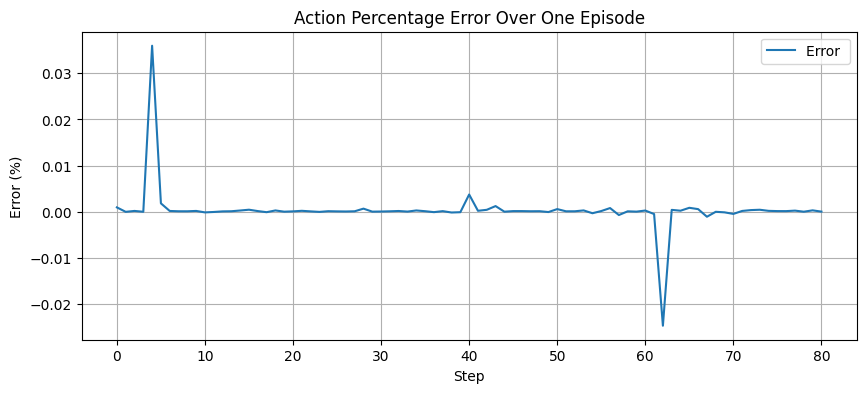

Loss: 0.028038285672664642
Loss: 0.2994341552257538
Loss: 0.03196204826235771
Loss: 0.2778208255767822
Loss: 0.027181057259440422
Loss: 0.23921248316764832
Loss: 0.020055755972862244
Loss: 0.19453532993793488
Loss: 0.013552255928516388
Loss: 0.14618715643882751
Loss: 0.010388514958322048
Loss: 0.10444427281618118
Loss: 0.0005206200294196606
Loss: 0.04927637428045273
Loss: 0.013411303050816059
Loss: 0.06265326589345932
Loss: 0.015901029109954834
Loss: 0.07017813622951508
Loss: 0.01755206100642681
Loss: 0.07514578104019165
Loss: 0.0174413975328207
Loss: 0.07315637171268463
Loss: 0.015681907534599304
Loss: 0.06914298236370087
Loss: 0.013271777890622616
Loss: 0.0616769976913929
Loss: 0.0094174575060606
Loss: 0.051618970930576324
Loss: 0.006850112695246935
Loss: 0.04370016232132912
Loss: 0.004568574018776417
Loss: 0.03210986778140068
Loss: 0.002518216148018837
Loss: 0.023593852296471596
Loss: 0.0012735225027427077
Loss: 0.017012855038046837
Loss: 0.0005671611288562417
Loss: 0.01252663973718

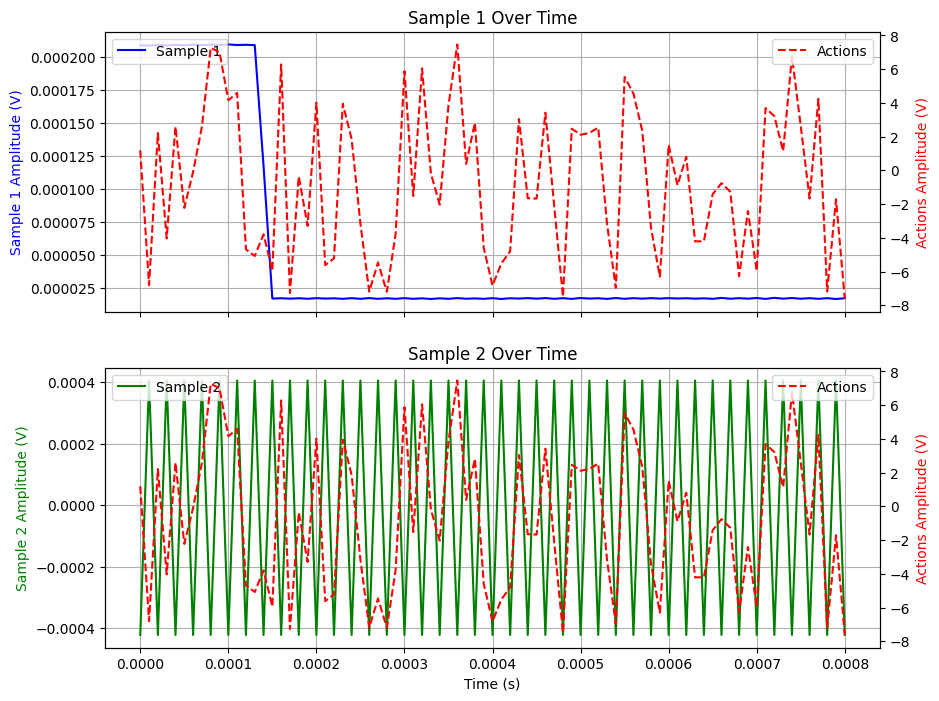

Data for run 8 saved to test\data_run_8.parquet
Deterministic:  False random:  True
Mu is: -0.8208805322647095, std is: 7.141675450839102e-05
Mu is: -0.7842212915420532, std is: 0.00010999432561220601
Mu is: -0.8208350539207458, std is: 7.142942922655493e-05
Mu is: -0.7843766212463379, std is: 0.00010979038052028045
Mu is: -0.8208738565444946, std is: 7.138719956856221e-05
Mu is: -0.7843983769416809, std is: 0.00010975918848998845
Mu is: -0.8209129571914673, std is: 7.134501356631517e-05
Mu is: -0.7843514680862427, std is: 0.00010980630031554028
Mu is: -0.8209129571914673, std is: 7.134501356631517e-05
Mu is: -0.7843297719955444, std is: 0.00010983760876115412
Mu is: -0.8208374381065369, std is: 7.139523950172588e-05
Mu is: -0.7843733429908752, std is: 0.00010977499186992645
Mu is: -0.8208738565444946, std is: 7.138719956856221e-05
Mu is: -0.7843514680862427, std is: 0.00010980630031554028
Mu is: -0.8060059547424316, std is: 9.84950820566155e-05
Mu is: -0.7969807386398315, std is: 0.00

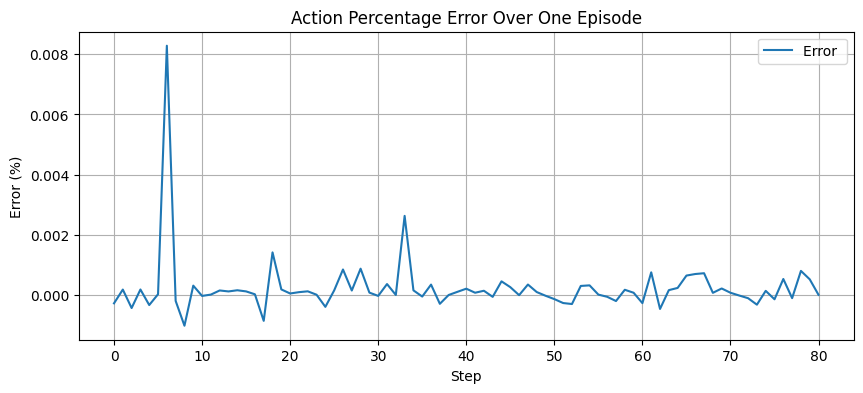

Loss: 0.19563722610473633
Loss: 0.0179535374045372
Loss: 0.17523512244224548
Loss: 0.017423225566744804
Loss: 0.14911046624183655
Loss: 0.013662494719028473
Loss: 0.12029644846916199
Loss: 0.011024962179362774
Loss: 0.09255768358707428
Loss: 0.007767131552100182
Loss: 0.06783369183540344
Loss: 0.004694852977991104
Loss: 0.0434613972902298
Loss: 0.0019612580072134733
Loss: 0.002335508819669485
Loss: 0.010520262643694878
Loss: 0.0652240440249443
Loss: 0.012930773198604584
Loss: 0.07204601913690567
Loss: 0.013140722177922726
Loss: 0.07430850714445114
Loss: 0.012550597079098225
Loss: 0.0721503421664238
Loss: 0.011043952777981758
Loss: 0.0664946511387825
Loss: 0.009257311932742596
Loss: 0.059582799673080444
Loss: 0.006836701650172472
Loss: 0.050923485308885574
Loss: 0.004212746862322092
Loss: 0.03964880108833313
Loss: 0.002582002431154251
Loss: 0.029113374650478363
Loss: 0.0012952217366546392
Loss: 0.021387001499533653
Loss: 0.00044178846292197704
Loss: 0.015375584363937378
Loss: 7.40473260

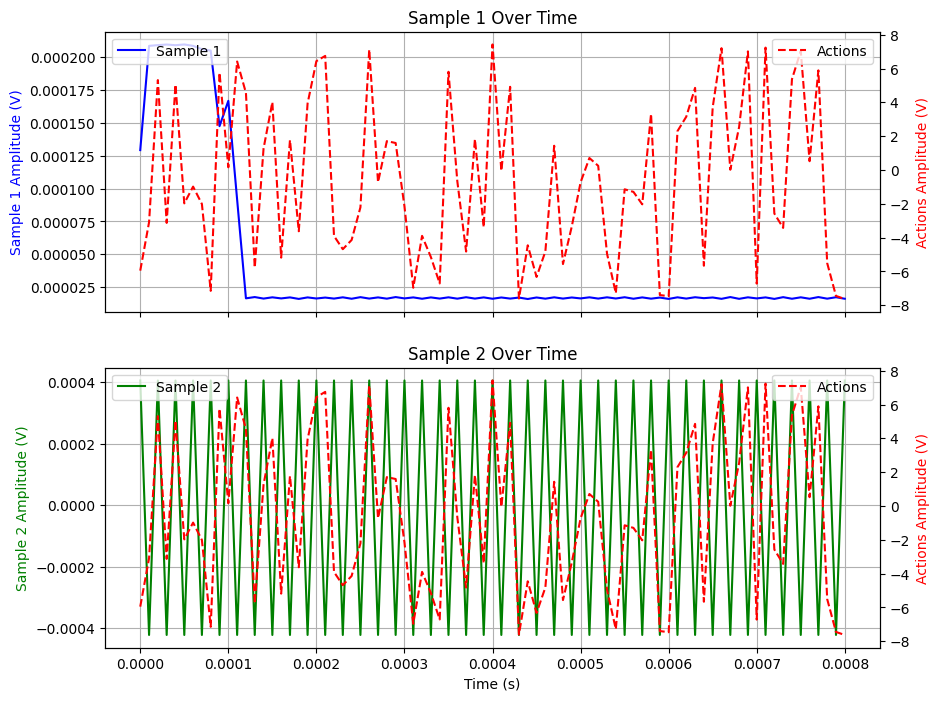

Data for run 9 saved to test\data_run_9.parquet
Deterministic:  False random:  True
Mu is: -0.7794674634933472, std is: 0.0001309950021095574
Mu is: -0.8093978762626648, std is: 8.180666191037744e-05
Mu is: -0.7775253057479858, std is: 0.00011658961011562496
Mu is: -0.8094044327735901, std is: 8.166183397406712e-05
Mu is: -0.7773933410644531, std is: 0.00011677075963234529
Mu is: -0.8095303773880005, std is: 8.153809903888032e-05
Mu is: -0.7773444652557373, std is: 0.00011687258665915579
Mu is: -0.8090937733650208, std is: 8.242555486503989e-05
Mu is: -0.7766287326812744, std is: 0.00011828272545244545
Mu is: -0.8019540905952454, std is: 9.844230953603983e-05
Mu is: -0.7750986218452454, std is: 0.00012823646829929203
Mu is: -0.7986776828765869, std is: 0.00011196808918612078
Mu is: -0.7957249283790588, std is: 0.00013511892757378519
Mu is: -0.7946085333824158, std is: 0.0001324126496911049
Mu is: -0.7957522869110107, std is: 0.00013512589794117957
Mu is: -0.794597864151001, std is: 0.0

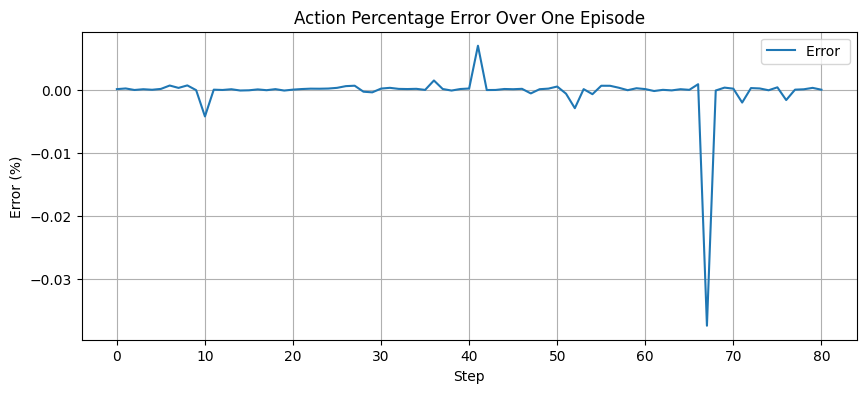

Loss: 0.0002976189716719091
Loss: 0.11925952136516571
Loss: 0.008545521646738052
Loss: 0.107347272336483
Loss: 0.007459326181560755
Loss: 0.09037327021360397
Loss: 0.006320014595985413
Loss: 0.06639477610588074
Loss: 0.003373623127117753
Loss: 0.011928917840123177
Loss: 0.00014622525486629456
Loss: 0.0003788720059674233
Loss: 0.0031937449239194393
Loss: 0.020619871094822884
Loss: 0.0031495955772697926
Loss: 0.023685691878199577
Loss: 0.0033692726865410805
Loss: 0.02523057349026203
Loss: 0.0035519255325198174
Loss: 0.02598189376294613
Loss: 0.0031321111600846052
Loss: 0.023866279050707817
Loss: 0.0026164266746491194
Loss: 0.021383576095104218
Loss: 0.0016357784625142813
Loss: 0.018684402108192444
Loss: 0.001028254278935492
Loss: 0.01489425078034401
Loss: 0.000507635239046067
Loss: 0.011038602329790592
Loss: 0.0005534692318178713
Loss: 0.0075943670235574245
Loss: 0.0002211286046076566
Loss: 0.005371204577386379
Loss: 0.00011961245036218315
Loss: 0.003848557360470295
Loss: 0.0001369537931

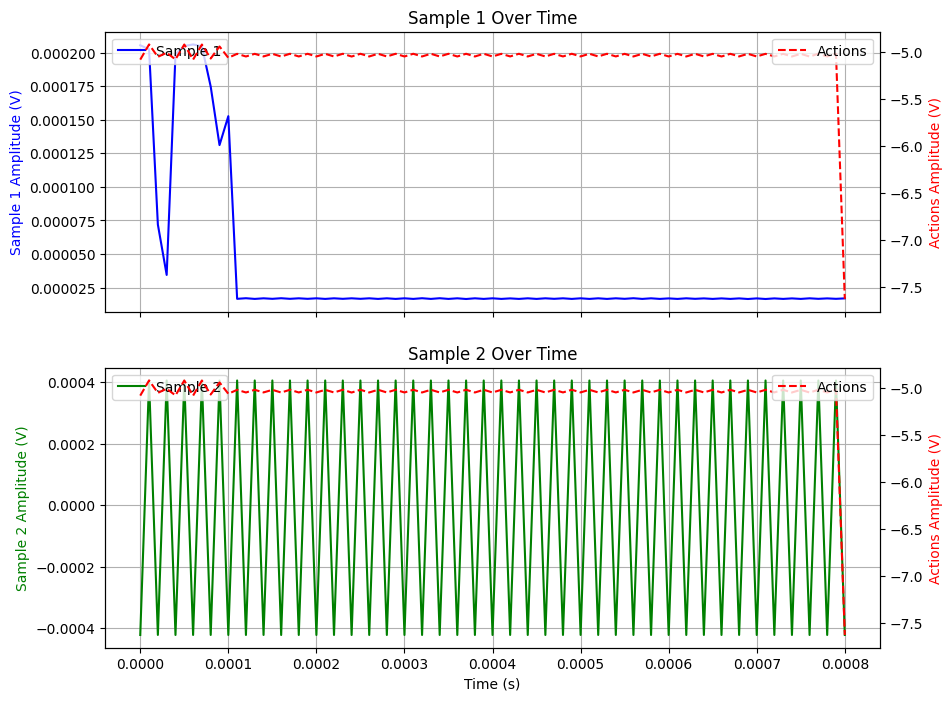

Data for run 10 saved to test\data_run_10.parquet
Deterministic:  True random:  False
Mu is: -0.8042017817497253, std is: 9.019154822453856e-05
Mu is: -0.7670994997024536, std is: 0.00012220816279295832
Mu is: -0.7973400354385376, std is: 0.00012098660226911306
Mu is: -0.7871673107147217, std is: 0.00013393042900133878
Mu is: -0.8036301136016846, std is: 9.1747468104586e-05
Mu is: -0.767261266708374, std is: 0.0001215413649333641
Mu is: -0.8041390180587769, std is: 9.016111289383844e-05
Mu is: -0.7673487663269043, std is: 0.00012146731751272455
Mu is: -0.8013966083526611, std is: 9.786858572624624e-05
Mu is: -0.7719390392303467, std is: 0.0001319789735134691
Mu is: -0.7995944023132324, std is: 0.00010351899254601449
Mu is: -0.7898232340812683, std is: 0.00013451554696075618
Mu is: -0.7963537573814392, std is: 0.0001336873392574489
Mu is: -0.7898330688476562, std is: 0.0001345170894637704
Mu is: -0.7962324023246765, std is: 0.0001338824222330004
Mu is: -0.7898232340812683, std is: 0.000

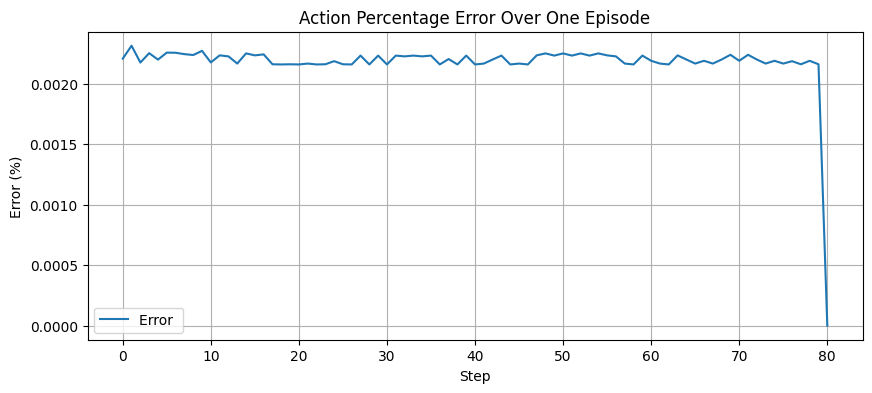

Loss: 0.07671363651752472
Loss: 0.004493737127631903
Loss: 0.0033561468590050936
Loss: 6.070896779419854e-05
Loss: 0.05591856688261032
Loss: 0.0033457933459430933
Loss: 0.048341408371925354
Loss: 0.003143445821478963
Loss: 0.019474036991596222
Loss: 0.00019580569642130286
Loss: 0.006254138890653849
Loss: 0.0013105247635394335
Loss: 0.011832726188004017
Loss: 0.0018702539382502437
Loss: 0.014910719357430935
Loss: 0.0014051804319024086
Loss: 0.01595143973827362
Loss: 0.001250555389560759
Loss: 0.016174299642443657
Loss: 0.0009950202656909823
Loss: 0.0156714990735054
Loss: 0.0007129285368137062
Loss: 0.01457364484667778
Loss: 0.0006136274896562099
Loss: 0.011320564895868301
Loss: 0.0006517449510283768
Loss: 0.008813221007585526
Loss: 0.00029329516110010445
Loss: 0.0065887365490198135
Loss: 9.321903780801222e-05
Loss: 0.00492900563403964
Loss: 7.951310544740409e-05
Loss: 0.0025116477627307177
Loss: 0.00017940756515599787
Loss: 0.0011733823921531439
Loss: 0.0002486170851625502
Loss: 0.00046

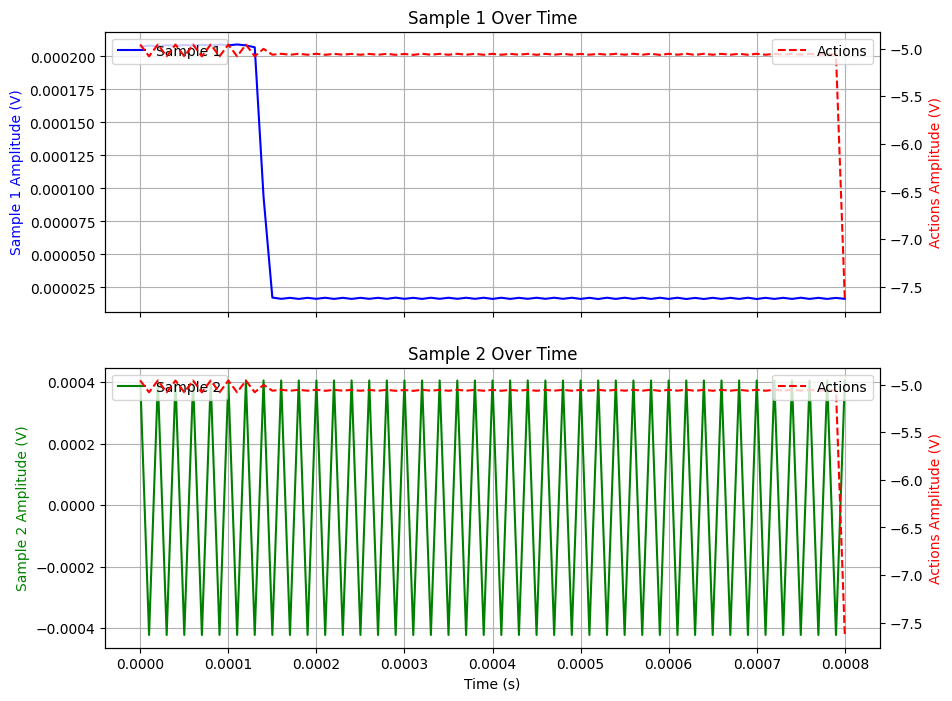

Data for run 11 saved to test\data_run_11.parquet
Deterministic:  False random:  False
Mu is: -0.7744134664535522, std is: 0.00012178072211099789
Mu is: -0.8033491969108582, std is: 9.436070104129612e-05
Mu is: -0.7744197845458984, std is: 0.00012171790149295703
Mu is: -0.803400993347168, std is: 9.42790211411193e-05
Mu is: -0.7745993137359619, std is: 0.00012144438369432464
Mu is: -0.8033252954483032, std is: 9.433946252102032e-05
Mu is: -0.7745258808135986, std is: 0.00012153753777965903
Mu is: -0.8034659028053284, std is: 9.417720866622403e-05
Mu is: -0.7745640873908997, std is: 0.00012147461529821157
Mu is: -0.8033900260925293, std is: 9.42376718739979e-05
Mu is: -0.7746021747589111, std is: 0.0001214118383359164
Mu is: -0.8034030199050903, std is: 9.421718277735636e-05
Mu is: -0.7747140526771545, std is: 0.00012125597277190536
Mu is: -0.8029624223709106, std is: 9.491241507930681e-05
Mu is: -0.7849724292755127, std is: 0.000132882603793405
Mu is: -0.7992706298828125, std is: 0.000

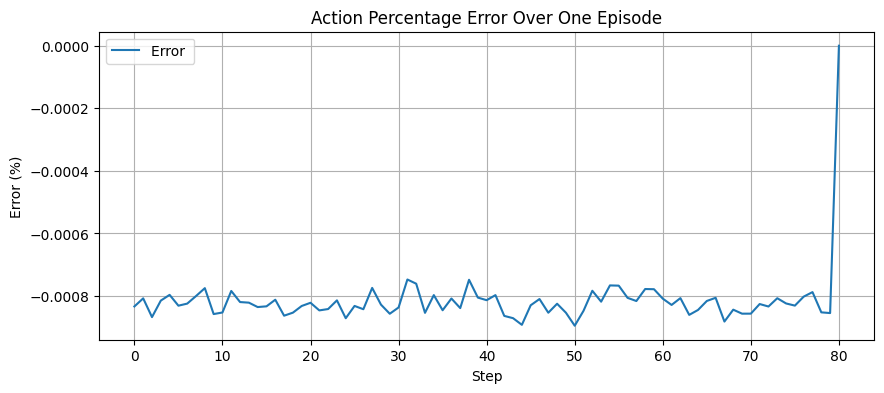

Loss: 0.004391846247017384
Loss: 0.05989361181855202
Loss: 0.003713735844939947
Loss: 0.054827410727739334
Loss: 0.00346117140725255
Loss: 0.04794788360595703
Loss: 0.001960253808647394
Loss: 0.03646529093384743
Loss: 0.0008874867926351726
Loss: 0.02257891744375229
Loss: 0.0005127377808094025
Loss: 0.014071390964090824
Loss: 9.245263208867982e-05
Loss: 0.0063974279910326
Loss: 0.0037526783999055624
Loss: 0.022979166358709335
Loss: 0.0046498957090079784
Loss: 0.026607630774378777
Loss: 0.004110194277018309
Loss: 0.028208855539560318
Loss: 0.0038998269010335207
Loss: 0.02670074813067913
Loss: 0.003136568469926715
Loss: 0.024353791028261185
Loss: 0.0020982965361326933
Loss: 0.020264405757188797
Loss: 0.0012372919591143727
Loss: 0.0152399567887187
Loss: 0.0006681451923213899
Loss: 0.011255920864641666
Loss: 0.0003258790238760412
Loss: 0.006855465471744537
Loss: 8.754307782510296e-05
Loss: 0.004837131593376398
Loss: 2.0390139980008826e-05
Loss: 0.0022589601576328278
Loss: 0.0001278718264074

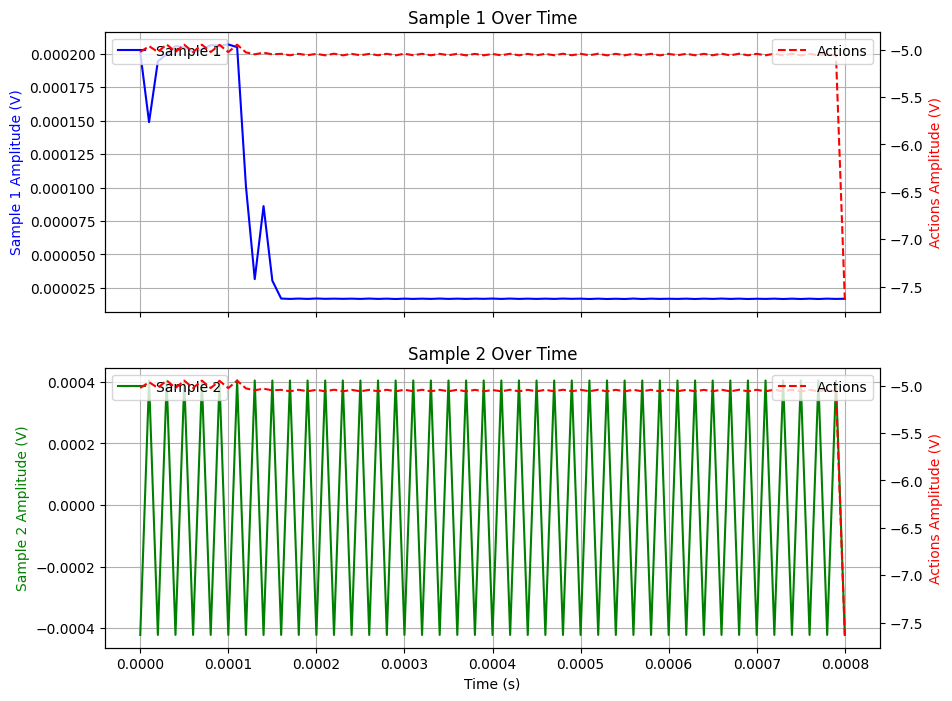

Data for run 12 saved to test\data_run_12.parquet
Deterministic:  False random:  False
Mu is: -0.790501594543457, std is: 0.00010518959606997669
Mu is: -0.7764250040054321, std is: 0.00013438821770250797
Mu is: -0.7902261018753052, std is: 0.00010664493311196566
Mu is: -0.7723104953765869, std is: 0.00012839370174333453
Mu is: -0.7903763651847839, std is: 0.00010454055154696107
Mu is: -0.7729634642601013, std is: 0.0001264642778551206
Mu is: -0.7903876900672913, std is: 0.00010529106657486409
Mu is: -0.772671639919281, std is: 0.0001271863584406674
Mu is: -0.7905129194259644, std is: 0.00010425282380310819
Mu is: -0.7730197310447693, std is: 0.0001262425648747012
Mu is: -0.7905250787734985, std is: 0.00010415324504720047
Mu is: -0.7728636264801025, std is: 0.00012660112406592816
Mu is: -0.7915683388710022, std is: 0.00012204149970784783
Mu is: -0.7961962223052979, std is: 0.00013473740546032786
Mu is: -0.7922717332839966, std is: 0.00012398110993672162
Mu is: -0.7962744832038879, std i

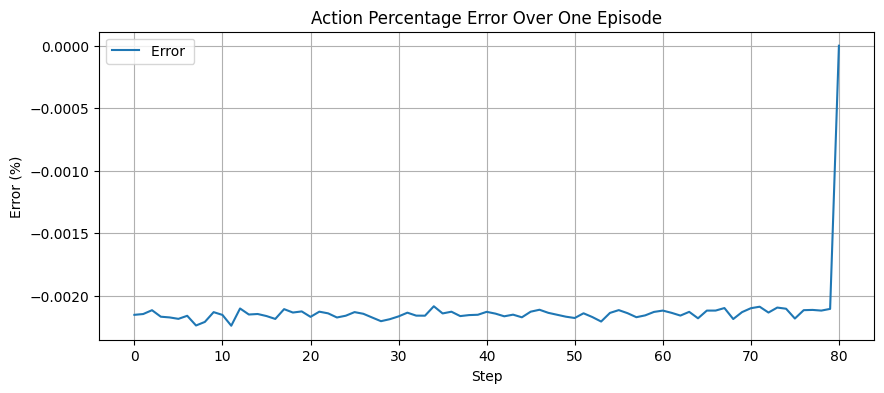

Loss: 0.02828054502606392
Loss: 0.0002928361063823104
Loss: 0.02363268844783306
Loss: 0.0008383783861063421
Loss: 0.02506903000175953
Loss: 0.0009371701162308455
Loss: 0.017512286081910133
Loss: 0.00035046535776928067
Loss: 0.013726934790611267
Loss: 0.0003962889895774424
Loss: 0.007763038855046034
Loss: 0.00018395396182313561
Loss: 0.0013439427129924297
Loss: 0.0019785386975854635
Loss: 0.004395727068185806
Loss: 0.002317806240171194
Loss: 0.014726362191140652
Loss: 0.0020937700755894184
Loss: 0.01524487417191267
Loss: 0.0016803081380203366
Loss: 0.014316773042082787
Loss: 0.0011580929858610034
Loss: 0.012641060166060925
Loss: 0.0007681375136598945
Loss: 0.009510297328233719
Loss: 0.0004239703412167728
Loss: 0.007318572141230106
Loss: 0.00013422488700598478
Loss: 0.004963185638189316
Loss: 3.104894858552143e-05
Loss: 0.003026978811249137
Loss: 1.0506699254619889e-05
Loss: 0.0012961140600964427
Loss: 0.00017533107893541455
Loss: 0.0008061949629336596
Loss: 0.0004589904274325818
Loss: 0

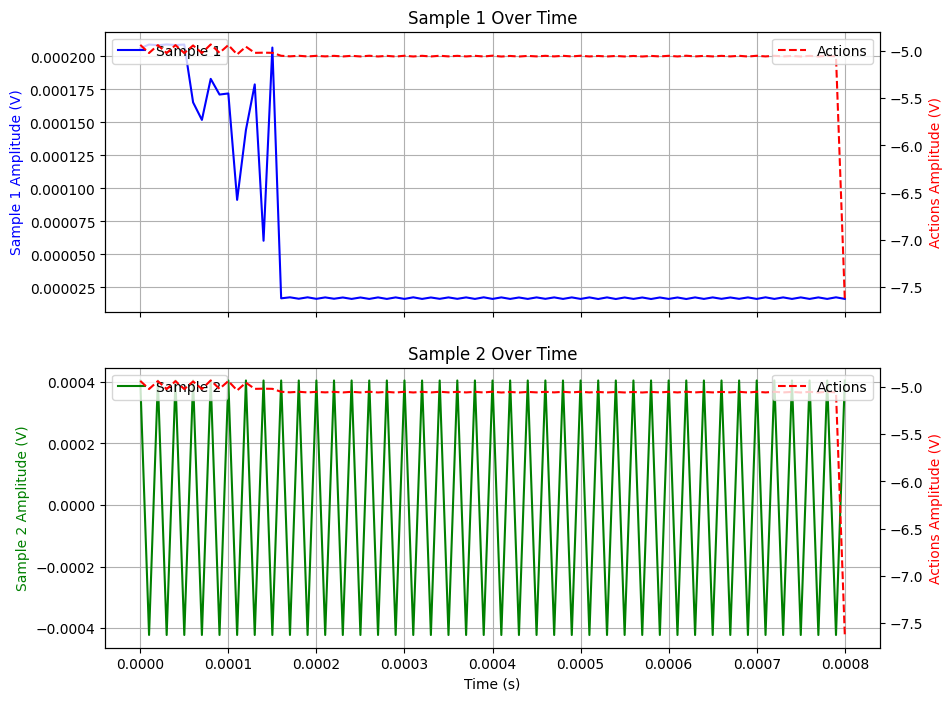

Data for run 13 saved to test\data_run_13.parquet
Deterministic:  False random:  False
Mu is: -0.7691377401351929, std is: 0.00012675492325797677
Mu is: -0.788904070854187, std is: 0.00010984033724525943
Mu is: -0.7696380615234375, std is: 0.0001257812255062163
Mu is: -0.7891418933868408, std is: 0.00010953864693874493
Mu is: -0.7696658968925476, std is: 0.00012572735431604087
Mu is: -0.7890143990516663, std is: 0.00010970287985401228
Mu is: -0.7705284357070923, std is: 0.00013388051593210548
Mu is: -0.7887334823608398, std is: 0.00012011894432362169
Mu is: -0.7681173086166382, std is: 0.00013297528494149446
Mu is: -0.7884837985038757, std is: 0.00011690480459947139
Mu is: -0.7695959210395813, std is: 0.00013357392163015902
Mu is: -0.7925902605056763, std is: 0.00012631349090952426
Mu is: -0.7736374735832214, std is: 0.00013450515689328313
Mu is: -0.7884740829467773, std is: 0.00011552144860615954
Mu is: -0.788138210773468, std is: 0.00013426881923805922
Mu is: -0.7884507179260254, std

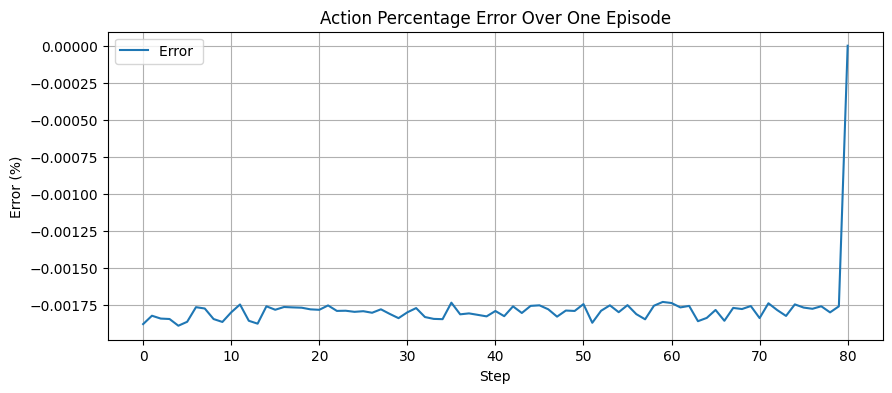

Loss: 0.0016627603909000754
Loss: 0.018926750868558884
Loss: 0.0016899955226108432
Loss: 0.01832754723727703
Loss: 0.001335415756329894
Loss: 0.014144621789455414
Loss: 0.0001967745483852923
Loss: 0.0018541028257459402
Loss: 0.00025341223226860166
Loss: 0.0019735584501177073
Loss: 0.0007799684535712004
Loss: 0.0004078836354892701
Loss: 0.001176246558316052
Loss: 0.0005937153473496437
Loss: 0.0010832312982529402
Loss: 0.0020587723702192307
Loss: 0.0010055152233690023
Loss: 0.007283810060471296
Loss: 0.000802495633251965
Loss: 0.00770661560818553
Loss: 0.0005637438734993339
Loss: 0.006645445711910725
Loss: 0.00031049709650687873
Loss: 0.005447124596685171
Loss: 0.00015200211782939732
Loss: 0.004571319092065096
Loss: 3.936857319786213e-05
Loss: 0.0038134802598506212
Loss: 9.575573130859993e-06
Loss: 0.0026349800173193216
Loss: 1.7389167624060065e-05
Loss: 0.001546354265883565
Loss: 0.00010339014988858253
Loss: 0.0009388537728227675
Loss: 0.00024171247787307948
Loss: 0.00044529218575917184

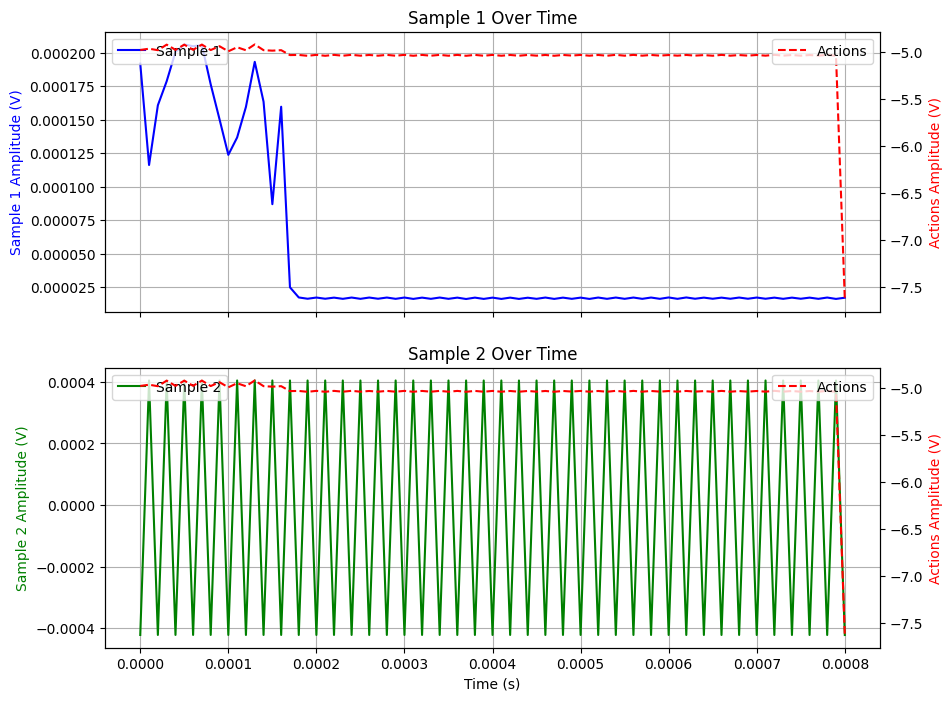

Data for run 14 saved to test\data_run_14.parquet
Deterministic:  False random:  False
Mu is: -0.7789101600646973, std is: 0.00011607615306274965
Mu is: -0.7758225798606873, std is: 0.00013432146806735545
Mu is: -0.7795453667640686, std is: 0.00012114640412619337
Mu is: -0.7661477327346802, std is: 0.00013288894842844456
Mu is: -0.7786142230033875, std is: 0.00011484621791169047
Mu is: -0.7662169337272644, std is: 0.00012685226101893932
Mu is: -0.7785271406173706, std is: 0.00011417547648306936
Mu is: -0.7661706805229187, std is: 0.00012701617379207164
Mu is: -0.7791090607643127, std is: 0.0001187363886856474
Mu is: -0.7700385451316833, std is: 0.00013423898781184107
Mu is: -0.7822762131690979, std is: 0.0001246055617230013
Mu is: -0.7722727060317993, std is: 0.0001343718176940456
Mu is: -0.7796881794929504, std is: 0.00012118706945329905
Mu is: -0.7654043436050415, std is: 0.0001305752812186256
Mu is: -0.7794907093048096, std is: 0.00012070251978002489
Mu is: -0.7808780074119568, std 

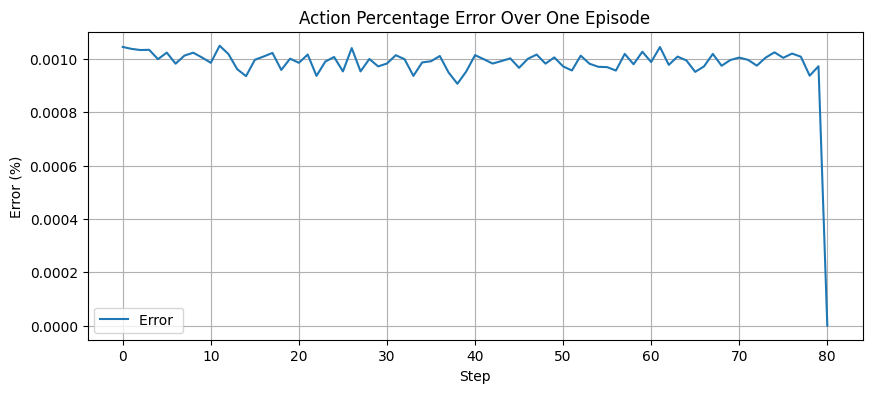

Loss: 0.009838801808655262
Loss: 0.00017714648856781423
Loss: 0.003953619860112667
Loss: 0.0001058093985193409
Loss: 0.008725632913410664
Loss: 0.0010898608015850186
Loss: 0.006515040993690491
Loss: 0.0007930414285510778
Loss: 0.0014744943473488092
Loss: 0.0002708060201257467
Loss: 5.491291085490957e-05
Loss: 0.00037177448393777013
Loss: 1.7223082977579907e-06
Loss: 3.128859316348098e-05
Loss: 9.138251698459499e-06
Loss: 0.00042802185635082424
Loss: 0.00014963338617235422
Loss: 0.000515646068379283
Loss: 0.0049781957641243935
Loss: 0.0004654773510992527
Loss: 0.0051484256982803345
Loss: 0.0002709689433686435
Loss: 0.004892845172435045
Loss: 0.0002091770147671923
Loss: 0.004250889178365469
Loss: 0.0001626744051463902
Loss: 0.003103371476754546
Loss: 5.529616464627907e-05
Loss: 0.0021079520229250193
Loss: 1.5583969798171893e-05
Loss: 0.001539836754091084
Loss: 5.5732461987645365e-06
Loss: 0.0007654259679839015
Loss: 2.803812822094187e-05
Loss: 0.00040098692988976836
Loss: 0.0001537080970

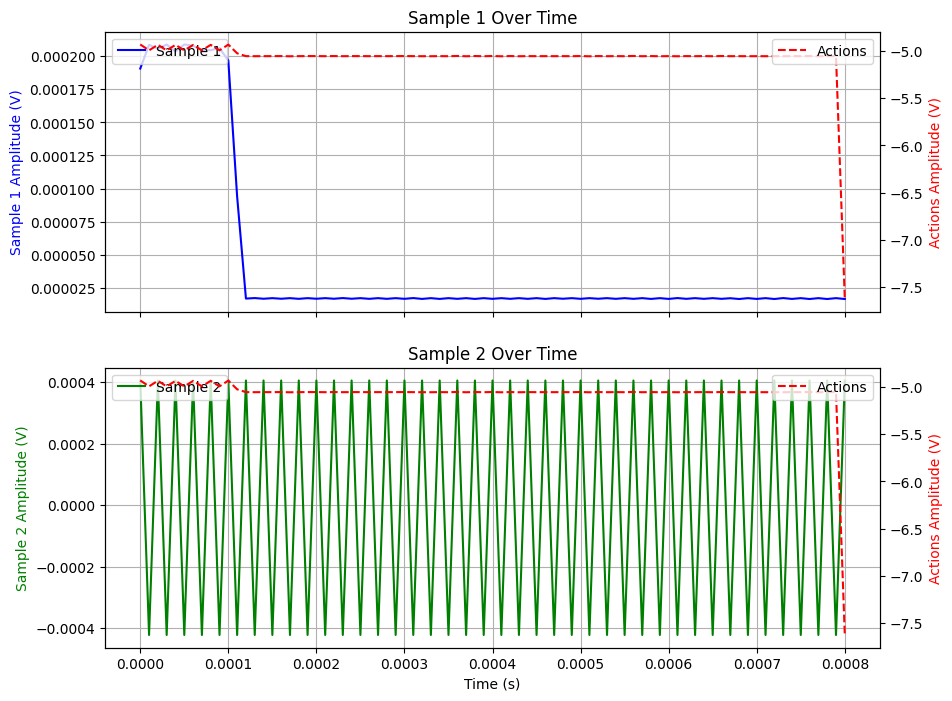

Data for run 15 saved to test\data_run_15.parquet
Deterministic:  False random:  False
Mu is: -0.7683751583099365, std is: 0.00013164924166630954
Mu is: -0.7825526595115662, std is: 0.00011699860624503344
Mu is: -0.7690891027450562, std is: 0.00012773164780810475
Mu is: -0.782579779624939, std is: 0.00011693603300955147
Mu is: -0.7689098119735718, std is: 0.00012836309906560928
Mu is: -0.7825955152511597, std is: 0.0001169088136521168
Mu is: -0.7693936824798584, std is: 0.00012689085269812495
Mu is: -0.7824837565422058, std is: 0.0001178231614176184
Mu is: -0.7691202163696289, std is: 0.00012786680599674582
Mu is: -0.7823117971420288, std is: 0.00011773320147767663
Mu is: -0.7685522437095642, std is: 0.00013018945173826069
Mu is: -0.7897305488586426, std is: 0.00012898599379695952
Mu is: -0.7963757514953613, std is: 0.00013356792624108493
Mu is: -0.7967751026153564, std is: 0.00013424167991615832
Mu is: -0.7965232133865356, std is: 0.00013338006101548672
Mu is: -0.796781063079834, std 

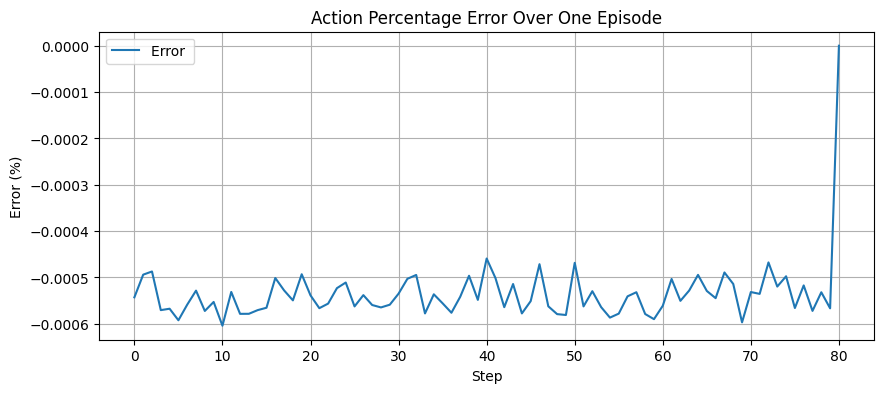

Loss: 0.0004579766246024519
Loss: 0.008674466982483864
Loss: 0.0009337951778434217
Loss: 0.007763753179460764
Loss: 0.0004779720038641244
Loss: 0.006374991964548826
Loss: 0.000679067219607532
Loss: 0.003843246027827263
Loss: 0.0003113358106929809
Loss: 0.002120422665029764
Loss: 2.8474207283579744e-05
Loss: 0.0006266412092372775
Loss: 0.001126432092860341
Loss: 0.003609444946050644
Loss: 0.0006376608507707715
Loss: 0.004003122448921204
Loss: 0.0005548066110350192
Loss: 0.004014325328171253
Loss: 0.0005487847956828773
Loss: 0.004062206484377384
Loss: 0.0005832281894981861
Loss: 0.003180738538503647
Loss: 0.0002522847498767078
Loss: 0.002253699814900756
Loss: 0.00021578608721029013
Loss: 0.0015745081473141909
Loss: 0.00014226671191863716
Loss: 0.0009139240719377995
Loss: 7.016255403868854e-05
Loss: 0.0005005752900615335
Loss: 1.1696896763169207e-05
Loss: 0.00010225657024420798
Loss: 0.00016887125093489885
Loss: 0.00018898904090747237
Loss: 0.0002811345912050456
Loss: 6.978414603509009e-0

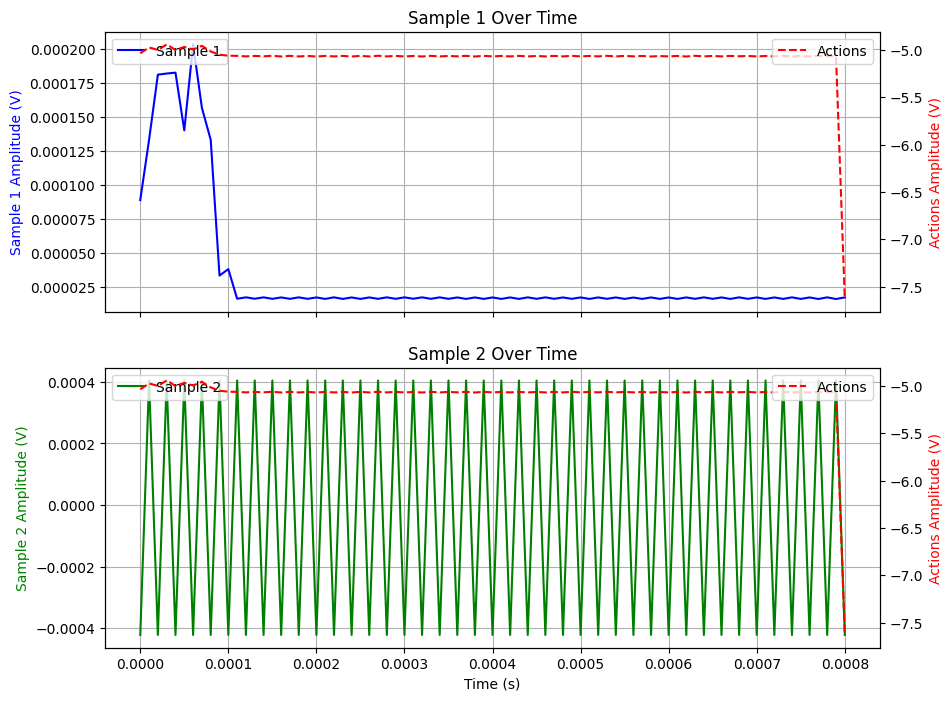

Data for run 16 saved to test\data_run_16.parquet
Deterministic:  False random:  False
Mu is: -0.7931416630744934, std is: 0.00013041734928265214
Mu is: -0.7788569331169128, std is: 0.00013514999591279775
Mu is: -0.784659206867218, std is: 0.00012457193224690855
Mu is: -0.7713785171508789, std is: 0.00013416566071100533
Mu is: -0.7847129106521606, std is: 0.00012421899009495974
Mu is: -0.7776191234588623, std is: 0.00013523998495656997
Mu is: -0.7836591005325317, std is: 0.00012174832227174193
Mu is: -0.7748407125473022, std is: 0.0001352584222331643
Mu is: -0.7884165048599243, std is: 0.00012852394138462842
Mu is: -0.7963742613792419, std is: 0.00013406640209723264
Mu is: -0.7985515594482422, std is: 0.00013261940330266953
Mu is: -0.7995158433914185, std is: 0.00013366261555347592
Mu is: -0.8007616400718689, std is: 0.0001335298438789323
Mu is: -0.7993899583816528, std is: 0.00013384998601395637
Mu is: -0.8007616400718689, std is: 0.0001335298438789323
Mu is: -0.7994011640548706, std 

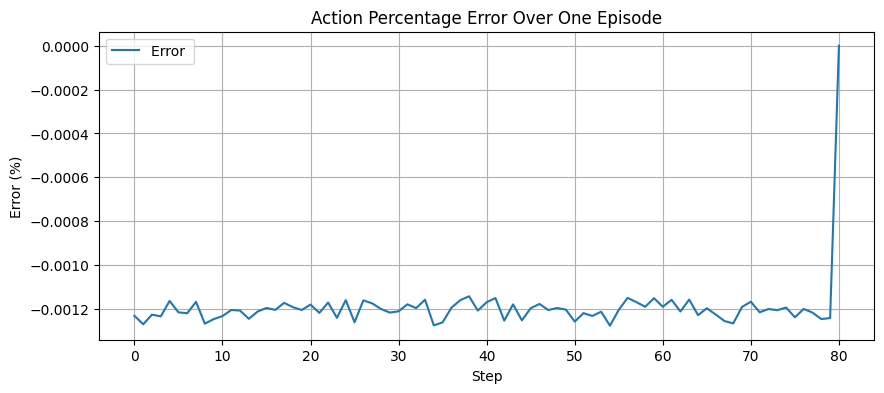

Loss: 0.00026267790235579014
Loss: 0.0002218222653027624
Loss: 0.0023821229115128517
Loss: 9.139155736193061e-05
Loss: 0.002231099409982562
Loss: 0.00010540991934249178
Loss: 0.0031898159068077803
Loss: 8.726275700610131e-05
Loss: 0.0002036418445641175
Loss: 0.00026615263777785003
Loss: 0.0003768106980714947
Loss: 0.00026484570116735995
Loss: 0.0004985522828064859
Loss: 0.00023540115216746926
Loss: 0.0006822018185630441
Loss: 0.00014929380267858505
Loss: 0.0010051976423710585
Loss: 0.0002004149428103119
Loss: 0.0009993943385779858
Loss: 0.00014811428263783455
Loss: 0.0005842081736773252
Loss: 2.0819470591959544e-05
Loss: 0.0005848634755238891
Loss: 0.00012363854330033064
Loss: 0.0004786744248121977
Loss: 0.00011840723891509697
Loss: 0.0002664308703970164
Loss: 1.897020047181286e-05
Loss: 0.00014144758461043239
Loss: 9.832638170337304e-05
Loss: 0.00024666989338584244
Loss: 0.00016106967814266682
Loss: 0.00014046489377506077
Loss: 9.143711395154241e-06
Loss: 5.032179979025386e-05
Loss: 5

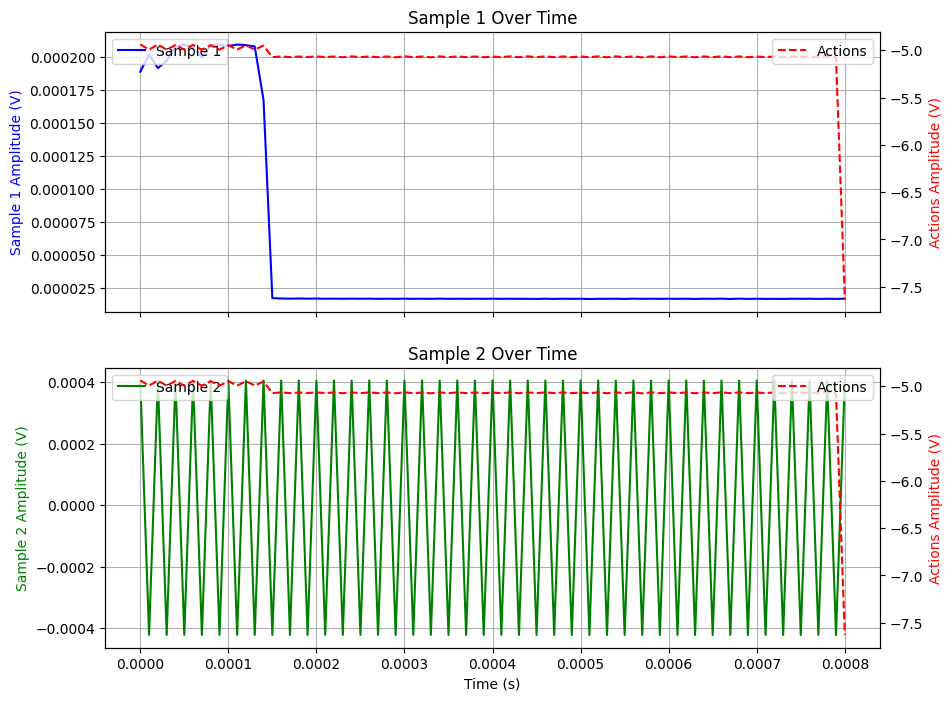

Data for run 17 saved to test\data_run_17.parquet
Deterministic:  False random:  False
Mu is: -0.7708448171615601, std is: 0.00013314811803866178
Mu is: -0.7831822633743286, std is: 0.00012398678518366069
Mu is: -0.7708795666694641, std is: 0.00013253482757136226
Mu is: -0.7835512757301331, std is: 0.00012437843543011695
Mu is: -0.7721779346466064, std is: 0.00012774857168551534
Mu is: -0.7832627892494202, std is: 0.00012264307588338852
Mu is: -0.7720295786857605, std is: 0.00012804093421436846
Mu is: -0.7832887172698975, std is: 0.0001242241996806115
Mu is: -0.7725082635879517, std is: 0.00012715882621705532
Mu is: -0.7832926511764526, std is: 0.00012258975766599178
Mu is: -0.7724137902259827, std is: 0.00012734401389025152
Mu is: -0.7833882570266724, std is: 0.0001224633160745725
Mu is: -0.7724477052688599, std is: 0.00012721850362140685
Mu is: -0.7831820249557495, std is: 0.00012291953316889703
Mu is: -0.7736944556236267, std is: 0.00013438155292533338
Mu is: -0.8014216423034668, st

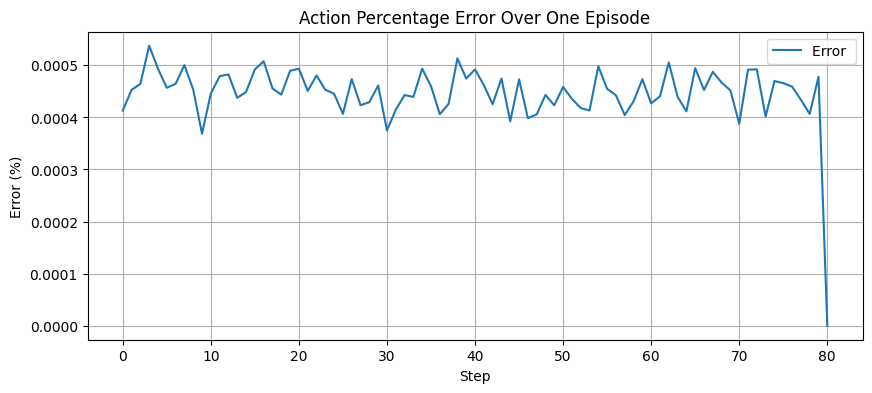

Loss: 0.00030642689671367407
Loss: 0.002707999898120761
Loss: 0.00011955636728089303
Loss: 0.0022490990813821554
Loss: 0.0009550493559800088
Loss: 0.002869510091841221
Loss: 0.000658112985547632
Loss: 0.0014487201115116477
Loss: 0.0007737884297966957
Loss: 0.0012557549634948373
Loss: 0.000470264843897894
Loss: 0.0007459489861503243
Loss: 0.0002989813801832497
Loss: 0.0002954537922050804
Loss: 0.0008867258438840508
Loss: 0.0016238397220149636
Loss: 0.0008376319892704487
Loss: 0.002108110347762704
Loss: 0.0006376674864441156
Loss: 0.0023014864418655634
Loss: 0.0005530891939997673
Loss: 0.0021218147594481707
Loss: 0.0005302999052219093
Loss: 0.0015828663017600775
Loss: 0.00029162236023694277
Loss: 0.0010548584396019578
Loss: 0.0001320399169344455
Loss: 0.0009943123441189528
Loss: 7.443205686286092e-05
Loss: 0.0006571396952494979
Loss: 6.754430069122463e-05
Loss: 0.0003826578613370657
Loss: 1.2356451861705864e-06
Loss: 0.00026967155281454325
Loss: 9.764519927557558e-05
Loss: 0.000224742892

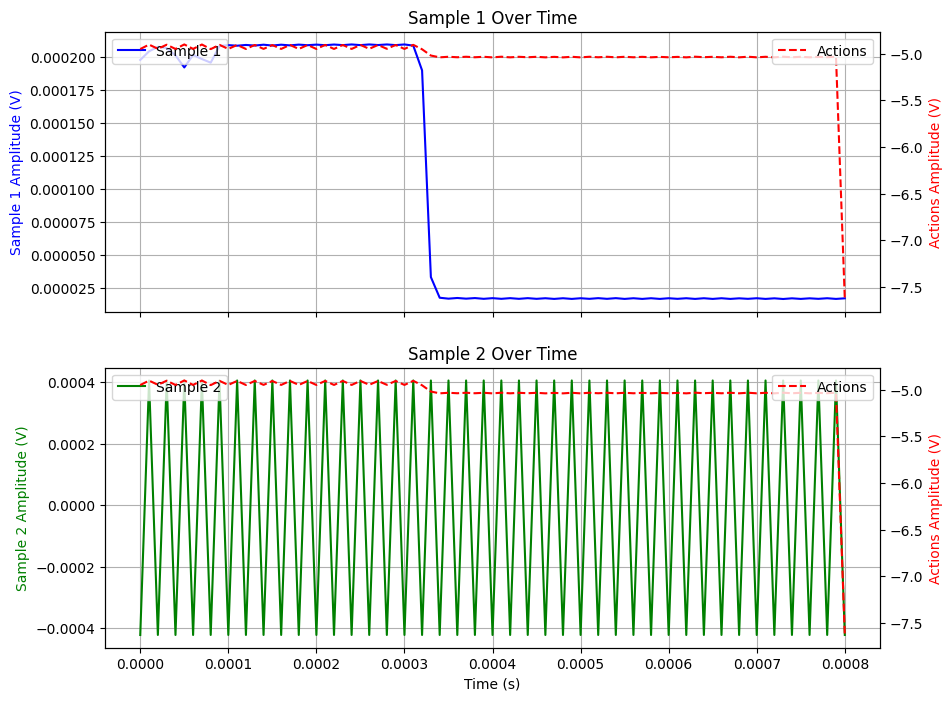

Data for run 18 saved to test\data_run_18.parquet
Deterministic:  False random:  False
Mu is: -0.7735064625740051, std is: 0.00012723985128104687
Mu is: -0.7625973224639893, std is: 0.0001310263469349593
Mu is: -0.772772490978241, std is: 0.00012638434418477118
Mu is: -0.7629328966140747, std is: 0.00013018038589507341
Mu is: -0.7731595039367676, std is: 0.00012704548134934157
Mu is: -0.7623914480209351, std is: 0.00013380494783632457
Mu is: -0.773138701915741, std is: 0.00012701241939794272
Mu is: -0.7624987363815308, std is: 0.00013235054211691022
Mu is: -0.773402214050293, std is: 0.00012779049575328827
Mu is: -0.7632553577423096, std is: 0.0001295149268116802
Mu is: -0.7728843092918396, std is: 0.00012605608208104968
Mu is: -0.7634072303771973, std is: 0.00012926702038384974
Mu is: -0.7729076743125916, std is: 0.00012600849731825292
Mu is: -0.7634330987930298, std is: 0.00012921389134135097
Mu is: -0.7729495763778687, std is: 0.00012592872371897101
Mu is: -0.7634330987930298, std i

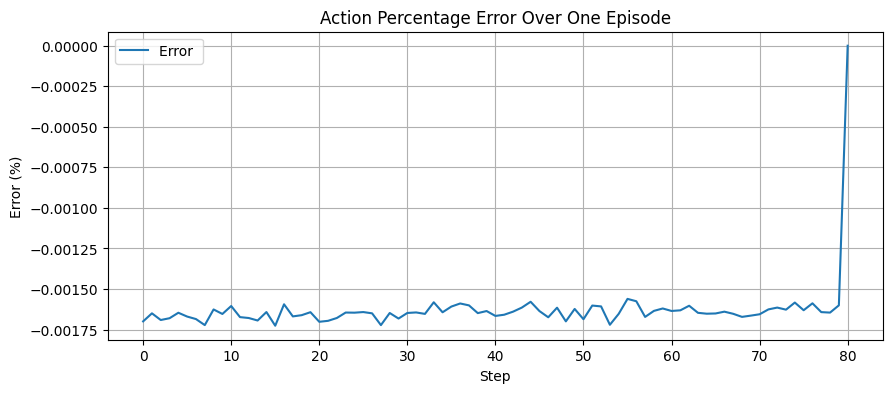

Loss: 0.0013685444137081504
Loss: 0.0005353694432415068
Loss: 0.0013299834681674838
Loss: 0.00038357696030288935
Loss: 0.0008746396633796394
Loss: 3.985269722761586e-05
Loss: 0.0006060957093723118
Loss: 3.876595656038262e-05
Loss: 0.0002921952400356531
Loss: 0.0003019277937710285
Loss: 0.0003883109020534903
Loss: 0.000272131321253255
Loss: 0.000183608615770936
Loss: 9.97499082586728e-05
Loss: 6.399719859473407e-05
Loss: 7.392624684143811e-05
Loss: 1.5810870536370203e-05
Loss: 6.931295501999557e-05
Loss: 5.420131856226362e-05
Loss: 3.386870230315253e-05
Loss: 3.480710802250542e-05
Loss: 1.2502399840741418e-05
Loss: 3.300725802546367e-05
Loss: 1.2469798093661666e-05
Loss: 8.020008681342006e-05
Loss: 3.0420605980907567e-05
Loss: 9.881652658805251e-05
Loss: 5.63094399694819e-05
Loss: 5.741134737036191e-05
Loss: 4.874070509686135e-05
Loss: 5.221014725975692e-05
Loss: 5.7998688134830445e-05
Loss: 0.0004839136090595275
Loss: 0.0009691942250356078
Loss: 0.0017417795024812222
Loss: 0.0007272553

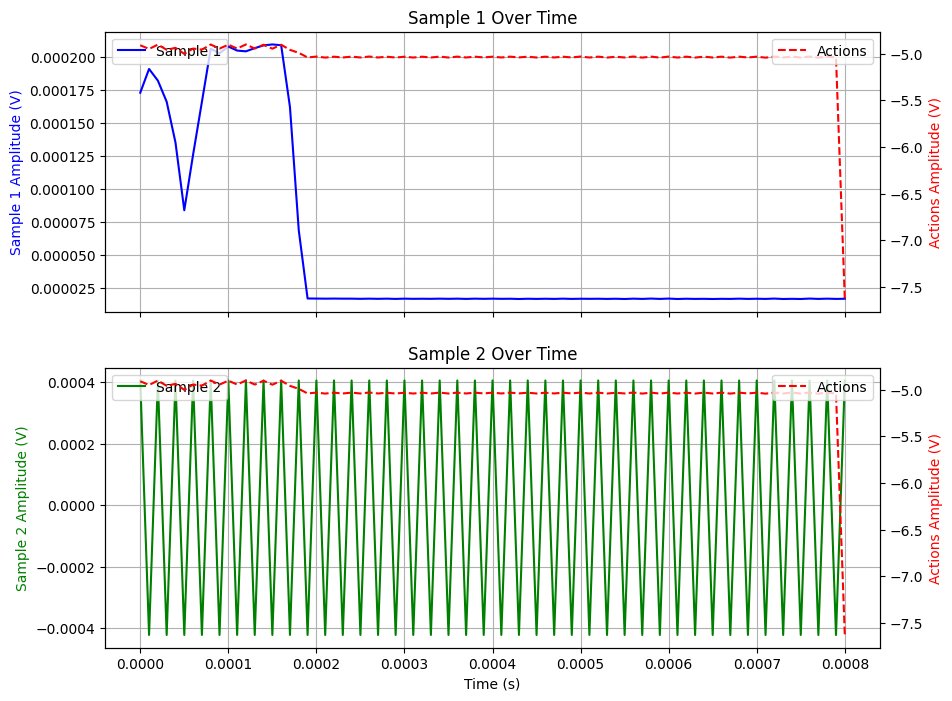

Data for run 19 saved to test\data_run_19.parquet
Deterministic:  False random:  False
Mu is: -0.7642656564712524, std is: 0.00013617998047266155
Mu is: -0.7732498049736023, std is: 0.0001293703680858016
Mu is: -0.7627740502357483, std is: 0.00013612376642413437
Mu is: -0.7751311659812927, std is: 0.00013164170377422124
Mu is: -0.770370364189148, std is: 0.00013653590576723218
Mu is: -0.7854184508323669, std is: 0.00013306812616065145
Mu is: -0.7720513343811035, std is: 0.0001363363116979599
Mu is: -0.7750216722488403, std is: 0.000131829030578956
Mu is: -0.7624269723892212, std is: 0.00013147231948096305
Mu is: -0.7724068760871887, std is: 0.000128216648590751
Mu is: -0.7627730369567871, std is: 0.0001307532365899533
Mu is: -0.7722626328468323, std is: 0.00012802029959857464
Mu is: -0.7622047066688538, std is: 0.0001320812152698636
Mu is: -0.7721408605575562, std is: 0.00012783351121470332
Mu is: -0.762952446937561, std is: 0.00013038191536907107
Mu is: -0.7724432945251465, std is: 0.

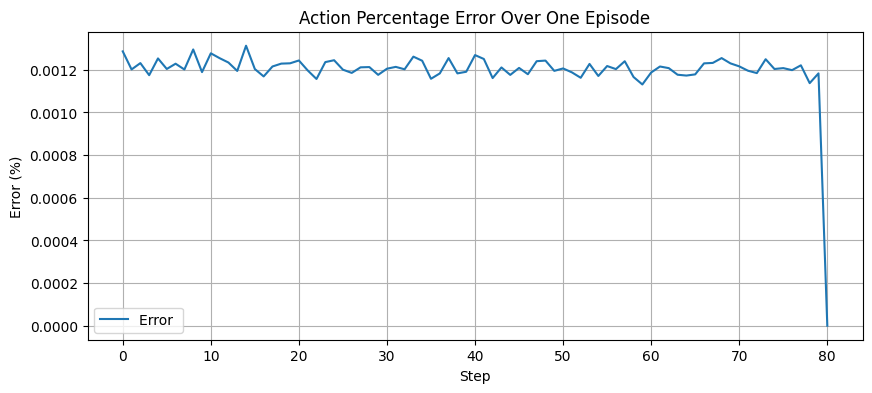

Loss: 0.0006971149705350399
Loss: 0.0005111347418278456
Loss: 0.00012864414020441473
Loss: 7.352807733695954e-05
Loss: 7.807297515682876e-05
Loss: 0.00012241773947607726
Loss: 0.00021060202561784536
Loss: 5.103019248053897e-06
Loss: 0.000586096488405019
Loss: 0.0004375062417238951
Loss: 0.0006855687825009227
Loss: 0.0004076074983458966
Loss: 0.0003862351004499942
Loss: 0.0002900291292462498
Loss: 0.0004020571068394929
Loss: 0.00029598770197480917
Loss: 0.00028761287103407085
Loss: 0.0003267555439379066
Loss: 0.00020982191199436784
Loss: 0.0006183749646879733
Loss: 0.0002556811668910086
Loss: 0.0004954281612299383
Loss: 0.00014655203267466277
Loss: 0.00042892451165243983
Loss: 0.0002666627988219261
Loss: 0.0006954523269087076
Loss: 0.00031624260009266436
Loss: 0.0004857644089497626
Loss: 0.00011119528790004551
Loss: 0.0002106755564454943
Loss: 4.535081097856164e-05
Loss: 0.00030631458503194153
Loss: 6.234437751118094e-05
Loss: 0.00024304239195771515
Loss: 6.433936505345628e-05
Loss: 0.0

In [7]:
experiment_folder = 'test'
server_ip = '192.168.1.10'
server_port = 7

errors = request_and_receive_data(server_ip, server_port, experiment_folder)

In [8]:
def analyze_errors(errors):
    # Calculate average percentage error
    avg_error = np.mean(errors)
    
    # Find maximum error
    max_error = np.max(errors)
    
    # Find minimum error
    min_error = np.min(errors)
    
    # Calculate standard deviation of the errors
    std_error = np.std(errors)
    
    # Print the calculated statistics
    print(f"Average Percentage Error: {avg_error:.8f}%")
    print(f"Maximum Error: {max_error:.8f}%")
    print(f"Minimum Error: {min_error:.8f}%")
    print(f"Standard Deviation: {std_error:.8f}%")
    
    # Plot the histogram
    plt.hist(errors, bins=100, edgecolor='black')
    plt.title("Histogram of Percentage Errors")
    plt.xlabel("Percentage Error")
    plt.ylabel("Frequency")
    plt.show()
    

Average Percentage Error: -0.00008447%
Maximum Error: 0.03600333%
Minimum Error: -0.03739811%
Standard Deviation: 0.00246109%


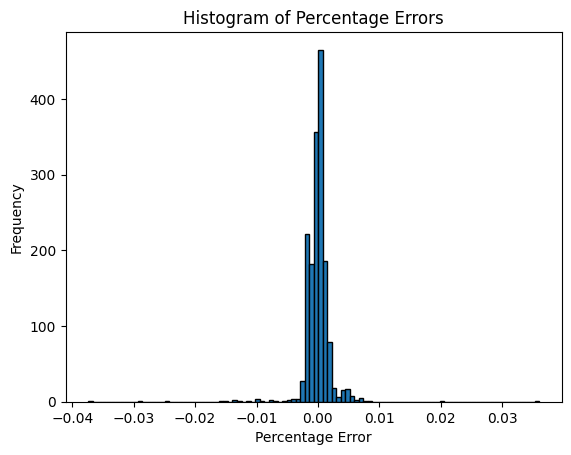

In [9]:
analyze_errors(errors)